In [52]:
import sys
sys.path.append("C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/MWLrepo/MiWayLife2/Data_Analysis_Package")
from data_preparation import DataPreparation, Analysis, multi_data_ops
import data_operations as do

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
import math
import matplotlib.gridspec as gridspec


import data_transforations as data_tr

from sklearn import tree

In [53]:
#functions for plotting continous features
def plot_histogram_boxplot_kde(data, title="Data Distribution", x_label="Value"):
    """
    Generates a combined plot showing a histogram with KDE, a box plot,
    and summary statistics.

    Args:
        data (array-like): A list, numpy array, or pandas Series of numerical data.
        title (str, optional): The main title for the plot. Defaults to "Data Distribution".
        x_label (str, optional): The label for the x-axis. Defaults to "Value".
    """
    # Convert data to a pandas Series to easily handle potential NaNs and calculations
    if not isinstance(data, pd.Series):
        data = pd.Series(data)

    # Drop NaN values to avoid errors in plotting and calculations
    print('Number of NaN values to be dropped: ',data.isnull().sum())
    data = data.dropna()

    if data.empty:
        print("Warning: Input data is empty or contains only NaN values. Cannot generate plot.")
        return

    # --- Calculate Statistics ---
    mean_val = data.mean()
    median_val = data.median()
    std_dev = data.std()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    count = len(data)

    # Format statistics for display
    stats_text = (
        f"Statistics:\n"
        f"-----------\n"
        f"Count: {count}\n"
        f"Mean: {mean_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"Std Dev: {std_dev:.2f}\n"
        f"Q1: {q1:.2f}\n"
        f"Q3: {q3:.2f}\n"
        f"IQR: {iqr:.2f}"
    )

    # --- Set up the plot layout ---
    # Create a figure
    fig = plt.figure(figsize=(10, 6))
    # Define the grid layout: 2 rows, 2 columns.
    # Top row for box plot, bottom row for histogram.
    # Right column for text.
    # Adjust width/height ratios for better spacing.
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                           figure=fig, wspace=0.1, hspace=0.05) # Reduced space

    # Create axes for each part of the plot
    ax_hist = fig.add_subplot(gs[1, 0])        # Histogram/KDE at bottom-left
    ax_box = fig.add_subplot(gs[0, 0], sharex=ax_hist) # Box plot at top-left, sharing x-axis
    ax_text = fig.add_subplot(gs[:, 1])        # Text box spanning both rows on the right

    # --- Plot the data ---
    # 1. Histogram and KDE plot (using seaborn for convenience)
    #    'bins="auto"' lets seaborn/numpy choose a suitable number of bins.
    #    'kde=True' adds the Kernel Density Estimate.
    sns.histplot(data, bins="auto", kde=True, ax=ax_hist, stat='density')
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel("Density")

    # Add vertical lines for mean and median
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean ({mean_val:.2f})')
    ax_hist.axvline(median_val, color='green', linestyle=':', linewidth=1.5, label=f'Median ({median_val:.2f})')
    ax_hist.legend(loc='upper right') # Add legend to histogram plot

    # 2. Box plot
    #    Use seaborn's boxplot for consistency.
    #    'orient='h'' makes it horizontal.
    sns.boxplot(x=data, ax=ax_box, orient='h', color='lightblue')
    ax_box.set_xlabel('') # Remove x-label as it's shared with histogram
    # Remove y-ticks and labels from boxplot for cleaner look
    ax_box.set_yticks([])
    ax_box.set_ylabel('') # Remove y-label

    # Remove ticks and labels from the top x-axis of the box plot
    plt.setp(ax_box.get_xticklabels(), visible=False)
    ax_box.tick_params(axis='x', which='both', bottom=False) # Remove ticks

    # 3. Statistics Text Box
    ax_text.axis('off') # Turn off the axis lines and ticks
    # Place the text in the center of the text axes
    ax_text.text(0.05, 0.5, stats_text, transform=ax_text.transAxes,
                 fontsize=10, verticalalignment='center',
                 bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.5))

    # --- Final Touches ---
    fig.suptitle(title, fontsize=16) # Add overall title
    # Adjust layout to prevent labels/titles overlapping
    # plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
    fig.subplots_adjust(top=0.92) # Adjust top margin for suptitle

#--------------------------------------------------------------------------------------------------------------------------------------------

# --- Helper function to plot distribution for a single category ---
# This adapts the logic from the previous function to draw on specific axes
def _plot_single_distribution(data, fig, ax,title="Distribution", x_label="Value"):
    """
    Helper function to draw histogram, KDE, box plot, and stats on a given Axes object
    by creating a nested GridSpec.

    Args:
        data (pd.Series): Numerical data for a single category (NaNs already handled).
        fig (matplotlib.figure.Figure): The main figure object.
        ax (matplotlib.axes.Axes): The main Axes object (from the outer grid)
                                   to draw this category's plot within.
        title (str): Title for this specific subplot.
        x_label (str): Label for the x-axis.
    """

    
  
    # Get the SubplotSpec from the parent Axes object
    ss = ax.get_subplotspec()
    # Turn off the axis frame/ticks for the original 'ax' as its space will be managed by the nested GridSpec
    ax.axis('off')

    if data.empty:
        # If data is empty, add text to the original Axes location
        ax.text(0.5, 0.5, "No data for this category",
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=10, color='grey')
        ax.set_title(title, fontsize=10) # Set title on the original Axes
        return

    # --- Calculate Statistics ---
    mean_val = data.mean()
    median_val = data.median()
    std_dev = data.std()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    count = len(data)

    # Format statistics
    stats_text = (
        f"N: {count}\n"
        f"Mean: {mean_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"StdDev: {std_dev:.2f}\n"
        f"Q1: {q1:.2f}\n"
        f"Q3: {q3:.2f}\n"
        f"IQR: {iqr:.2f}"
    )

    # --- Create inset axes within the main 'ax' space using its SubplotSpec ---
    gs_inset = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=ss, # Use the SubplotSpec here
                                                width_ratios=[4, 1], height_ratios=[1, 4],
                                                wspace=0.05, hspace=0.05)

    # Create the actual Axes using the main figure and the nested GridSpec indices
    ax_hist = fig.add_subplot(gs_inset[1, 0]) # Histogram at bottom-left
    ax_box = fig.add_subplot(gs_inset[0, 0], sharex=ax_hist) # Box plot at top-left
    ax_text = fig.add_subplot(gs_inset[:, 1]) # Text box on the right

    # --- Plot the data ---
    # 1. Histogram and KDE
    sns.histplot(data, bins="auto", kde=True, ax=ax_hist, stat='density')
    ax_hist.set_xlabel(x_label, fontsize=9) # Slightly smaller font for subplot labels
    ax_hist.set_ylabel("Density", fontsize=9)
    ax_hist.tick_params(axis='both', which='major', labelsize=8) # Smaller tick labels

    # Add vertical lines for mean and median
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean ({mean_val:.2f})')
    ax_hist.axvline(median_val, color='green', linestyle=':', linewidth=1, label=f'Median ({median_val:.2f})')
    ax_hist.legend(fontsize='x-small', loc='upper right') # Smaller legend

    # 2. Box plot
    sns.boxplot(x=data, ax=ax_box, orient='h', color='lightblue')
    ax_box.set_xlabel('')
    ax_box.set_yticks([])
    ax_box.set_ylabel('')
    plt.setp(ax_box.get_xticklabels(), visible=False)
    ax_box.tick_params(axis='x', which='both', bottom=False)

    # 3. Statistics Text Box
    ax_text.axis('off')
    ax_text.text(0.05, 0.5, stats_text, transform=ax_text.transAxes,
                 fontsize=8, verticalalignment='center',
                 bbox=dict(boxstyle='round,pad=0.3', fc='aliceblue', alpha=0.5))

    # Set the title for the specific subplot (category) on the original Axes container
    ax.set_title(title, fontsize=10)

#--------------------------------------------------------------------------------------------------------------------------------------------------

# --- Main function to create the grid plot ---
def plot_grouped_distributions(df, value_col, category_col='none',cat_list = [], main_title="Grouped Distributions"):
    """
    Generates a grid of distribution plots (hist, KDE, boxplot, stats)
    for numerical data grouped by a categorical column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        value_col (str): The name of the column with numerical data.
        category_col (str): The name of the column with categorical data.
        main_title (str, optional): The main title for the entire figure.
                                    Defaults to "Grouped Distributions".
    """

    if category_col == 'none':
        
        plot_histogram_boxplot_kde(df[value_col], title=f"Distribution of {value_col}", x_label=value_col)

    else:

        # Check if columns exist
        if value_col not in df.columns:
            print(f"Error: Value column '{value_col}' not found in DataFrame.")
            return
        if category_col not in df.columns:
            print(f"Error: Category column '{category_col}' not found in DataFrame.")
            return

        if len(cat_list) != 0:
            df = df[df[category_col].isin(cat_list)].copy()

        # Get unique categories and handle potential NaNs in category column
        # Sort categories for consistent plot order
        categories = sorted(df[category_col].dropna().unique())
        n_categories = len(categories)

        if n_categories == 0:
            print(f"Warning: No valid categories found in column '{category_col}'. Cannot generate plot.")
            return

        # --- Determine grid layout ---
        # Aim for a layout that's roughly square
        ncols = math.ceil(math.sqrt(n_categories))
        nrows = math.ceil(n_categories / ncols)

        # --- Create figure and subplots ---
        # Adjust figsize based on grid size for better readability
        # Increased base size slightly for better spacing within subplots
        fig_width = ncols * 5.5
        fig_height = nrows * 4.5
        fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), squeeze=False)

        # Flatten axes array for easy iteration
        axes_flat = axes.flatten()

        # --- Plot data for each category ---
        for i, category in enumerate(categories):
            ax = axes_flat[i]
            # Filter data for the current category, dropping NaNs in the value column
            category_data = df[df[category_col] == category][value_col].dropna()

            # Call the helper function to plot on the current axes
            # Pass the main 'fig' object as well
            _plot_single_distribution(category_data, fig, ax, # Pass fig and ax
                                      title=f"{category}", # Simpler title, category name only
                                      x_label=value_col)

        # --- Clean up unused subplots ---
        for i in range(n_categories, len(axes_flat)):
            axes_flat[i].axis('off') # Hide unused axes

        # --- Final Touches ---
        # Add a more descriptive main title including column names
        full_main_title = f"{main_title}: {value_col} by {category_col}"
        fig.suptitle(full_main_title, fontsize=16, y=1.0) # Adjust title position slightly
        # Use tight_layout first, then adjust spacing if needed
        plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust rect to prevent overlap and make space for title/labels
        # plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3) # Fine-tune spacing if tight_layout isn't enough

    plt.show()

plot_grouped_distributions(near_f.df, value_col, category_col=catgory_col,cat_list = [], main_title="Grouped Distributions")


In [54]:
#functions for plotting categorical data
def single_bar(data, fig=None, ax=None, title="none", x_label='none'):
    """
    Creates a single bar plot with statistics for categorical data.
    
    Parameters:
    - data: Series containing categorical data
    - fig: Figure object (optional)
    - ax: Axes object (optional)
    - title: Plot title (optional)
    - x_label: X-axis label (optional)
    """
    # Create new figure if none provided
    if fig is None or ax is None:
        fig = plt.figure(figsize=(10, 6))
        gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[0, 1], 
                             figure=fig, wspace=0.1, hspace=0.2)
        ax_bar = fig.add_subplot(gs[1, 0])
        ax_text = fig.add_subplot(gs[:, 1])
    else:
        # Use existing axes if provided
        ax_bar = ax
        ax_text = None  # We won't show stats when using subplots
    
    # Calculate statistics
    value_counts = data.value_counts()
    most_freq_count = value_counts.iloc[0] if not value_counts.empty else 0
    total = len(data.dropna())
    
    # Plot bar graph
    value_counts.plot(kind='bar', ax=ax_bar)
    ax_bar.set_xlabel(x_label if x_label != 'none' else data.name, fontsize=9)
    ax_bar.set_ylabel("Count", fontsize=9)
    ax_bar.tick_params(axis='both', which='major', labelsize=8)
    
    if title != "none":
        ax_bar.set_title(title, fontsize=10)
    
    # Add statistics text if we're not in a subplot
    if ax_text is not None:
        stats_text = (
            f"Distinct Count: {data.nunique()}\n"
            f"Mode: {value_counts.index[0] if not value_counts.empty else 'N/A'}\n"
            f"Mode Frequency: {most_freq_count} ({round((most_freq_count/total)*100, 2)}%)\n"
            f"Total Count: {total}\n"
            f"Missing Values: {data.isna().sum()}"
        )
        
        ax_text.axis('off')
        ax_text.text(0.05, 0.5, stats_text, transform=ax_text.transAxes,
                    fontsize=8, verticalalignment='center',
                    bbox=dict(boxstyle='round,pad=0.3', fc='aliceblue', alpha=0.5))
        
        if title == "none":
            fig.suptitle(f"Distribution of {data.name}", fontsize=12, y=0.95)

def categorical_bar_plot(df, value_col, category_col='none', cat_list=[], main_title="Grouped Distributions"):
    """
    Creates bar plots for categorical data, optionally grouped by another category.
    
    Parameters:
    - df: DataFrame containing the data
    - value_col: Column name for the categorical variable to plot
    - category_col: Column name to group by (optional)
    - cat_list: List of specific categories to include (optional)
    - main_title: Main title for the plot (optional)
    """
    if category_col == 'none':
        single_bar(df[value_col])
        plt.tight_layout()
        plt.show()
    else:
        if len(cat_list) != 0:
            df = df[df[category_col].isin(cat_list)].copy()

        # Get unique categories and handle potential NaNs
        categories = sorted(df[category_col].dropna().unique())
        n_categories = len(categories)

        if n_categories == 0:
            print(f"Warning: No valid categories found in column '{category_col}'. Cannot generate plot.")
            return

        # Determine grid layout
        ncols = min(3, math.ceil(math.sqrt(n_categories)))
        nrows = math.ceil(n_categories / ncols)

        # Create figure and subplots
        fig_width = ncols * 6
        fig_height = nrows * 5
        fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), squeeze=False)
        axes_flat = axes.flatten()

        # Plot data for each category
        for i, category in enumerate(categories):
            category_data = df[df[category_col] == category][value_col].dropna()
            
            # Plot directly on the subplot axes without stats box
            value_counts = category_data.value_counts()
            value_counts.plot(kind='bar', ax=axes_flat[i])
            axes_flat[i].set_title(f"{category}", fontsize=10)
            axes_flat[i].set_xlabel(value_col if i >= (nrows-1)*ncols else '')
            axes_flat[i].set_ylabel("Count" if i % ncols == 0 else '')

        # Hide unused subplots
        for i in range(n_categories, len(axes_flat)):
            axes_flat[i].axis('off')

        # Add main title and adjust layout
        fig.suptitle(f"{main_title}: {value_col} by {category_col}", fontsize=14, y=1.0)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()

categorical_bar_plot(near_f.df, value_col, category_col=category_col,cat_list = [], main_title="Grouped Distributions")

In [4]:
#gropuping function using decision trees
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split


def group_by_decision_tree(model, column_data, column_name):
    """
    Groups a pandas Series into categorical bands based on the leaf nodes of a
    fitted Decision Tree Classifier model.

    This function first traverses the decision tree to determine the value ranges
    for each leaf node. It then applies the model to the input column data to get
    the leaf node index for each data point and uses the collected ranges to
    assign a categorical band.

    Args:
        model (sklearn.tree.DecisionTreeClassifier): A fitted decision tree model.
        column_data (pd.Series): The pandas Series to be grouped.
        column_name (str): The name of the column in the original DataFrame
                           that the decision tree was trained on.

    Returns:
        pd.Series: A new pandas Series containing the categorical bands.
    """
    # Ensure the model is a decision tree
    if not isinstance(model, DecisionTreeClassifier):
        raise TypeError("The provided model must be an instance of DecisionTreeClassifier.")
    
    tree = model.tree_
    
    # Check if the tree is empty or not fitted
    if tree.node_count == 0:
        raise ValueError("The decision tree model does not seem to be fitted.")

    # A helper dictionary to store the min/max range for each leaf node
    leaf_ranges = {}
    
    def traverse_tree(node_index, lower_bound=float('-inf'), upper_bound=float('inf')):
        """
        Recursively traverses the tree to find the value range for each leaf node.
        """
        # Base case: if it's a leaf node
        if tree.children_left[node_index] == tree.children_right[node_index]:
            leaf_ranges[node_index] = (lower_bound, upper_bound)
            return

        threshold = tree.threshold[node_index]
        left_child = tree.children_left[node_index]
        right_child = tree.children_right[node_index]

        # Recurse down the left child (less than or equal to threshold)
        traverse_tree(left_child, lower_bound, min(upper_bound, threshold))

        # Recurse down the right child (greater than threshold)
        traverse_tree(right_child, max(lower_bound, threshold), upper_bound)

    # Start the traversal from the root node (index 0)
    traverse_tree(0)

    # Use the model's apply method to get the leaf node for each data point
    # We need to reshape the data to a 2D array for the model
    leaf_indices = model.apply(column_data.values.reshape(-1, 1))

    # Create the new column of grouped bands
    grouped_bands = []
    for index in leaf_indices:
        lower, upper = leaf_ranges[index]

        # Format the string for the band
        if lower == float('-inf'):
            band = f"< {upper:.2f}"
        elif upper == float('inf'):
            band = f"> {lower:.2f}"
        else:
            band = f"{lower:.2f} - {upper:.2f}"
        
        grouped_bands.append(band)

    return pd.Series(grouped_bands, index=column_data.index, name=f'{column_name}_bands')








# Loading data

In [ ]:
path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/"

inception_data = pd.DataFrame(pd.read_csv(path+"inception_data.csv"))
inception_data.drop(columns=['Unnamed: 0'], inplace=True)
near_ftr_lapse_data = pd.DataFrame(pd.read_csv(path+"near_ftr_lapse_data.csv"))
near_ftr_lapse_data = near_ftr_lapse_data.drop(columns=['Unnamed: 0'])

# Redoing data

In [5]:
path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/"

calls_data = pd.DataFrame(pd.read_csv(path+"call_reason.csv"))
sales_data = pd.DataFrame(pd.read_csv(path+"sales.csv"))
policy_data = pd.DataFrame(pd.read_csv(path+"policy_data.csv"))
payment_data = pd.concat([pd.DataFrame(pd.read_csv(path+"Payment_data_1.csv")),pd.DataFrame(pd.read_csv(path+"Payment_data_2.csv"))])
lapse_data = pd.concat([pd.DataFrame(pd.read_csv(path+"lapse_1.csv")),pd.DataFrame(pd.read_csv(path+"lapse_2.csv"))])

## Filtering data to relevant policies

Relevant policies are policies that have been incepted. The rpt_datamodel_lapse has incepted policies only, hence filtering on policies within that dataset

In [6]:
pol_names = list(lapse_data['policy_name'])
sales_data = sales_data[sales_data['policy_name'].isin(pol_names)]
pol_ids= list(sales_data['policy_id'])
calls_data = calls_data[calls_data['policy_name'].isin(pol_names)]
payment_data = payment_data[payment_data['policy_id'].isin(pol_ids)]
policy_data = policy_data[policy_data['policy_name'].isin(pol_names)]

#Make date column of data type datetime
sales_data=do.dtype_datetime(sales_data)
calls_data=do.dtype_datetime(calls_data)
payment_data=do.dtype_datetime(payment_data)
policy_data=do.dtype_datetime(policy_data)
lapse_data=do.dtype_datetime(lapse_data)


In [7]:
len(set(pol_names)),len(set(pol_ids)),sales_data['policy_id'].nunique(), calls_data['policy_name'].nunique(), payment_data['policy_id'].nunique(),policy_data['policy_name'].nunique()

(65364, 65364, 65364, 39590, 63981, 65364)

## Aggregating call, payment, sales and lapse data then merging

In [8]:
pre_inception_calls_data = data_tr.pre_sale_calls(calls_data,policy_data)
post_sale_calls_data = data_tr.post_sale_calls(calls_data,policy_data)
payment_hist_data = data_tr.payments_history(payment_data,current_date='2025-08-01')
lapse_data = data_tr.lapses(lapse_data)
sales_data = sales_data.drop_duplicates(subset=['policy_id'], keep='last')

c:\Users\E1005279\OneDrive - Sanlam Life Insurance Limited\MWL\MWLrepo\LapseRate_modeling\data_transforations.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls.df['res_code']= calls.df['resolution_code'].apply(res_code_categories)
c:\Users\E1005279\OneDrive - Sanlam Life Insurance Limited\MWL\MWLrepo\LapseRate_modeling\data_transforations.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls.df['res_code']= calls.df['resolution_code'].apply(res_code_categories_postsale)
c:\Users\E1005279\OneD

In [9]:
inception_data = data_tr.at_inception_data_merge(pre_inception_calls_data, sales_data,policy_data,lapse_data)
near_ftr_lapse_data = data_tr.post_sale_data_merge(post_sale_calls_data, sales_data,policy_data,lapse_data,payment_hist_data)

In [ ]:
near_ftr_lapse_data

# Exploratory Data Analysis

## At point of inception data

In [55]:
path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/Data2/"

inception_data = pd.DataFrame(pd.read_csv(path+"inception_data_eco_v3.csv"))
inception_data.drop(columns=['Unnamed: 0'], inplace=True)

In [56]:
at_inception =DataPreparation(df=inception_data)
at_inception.null_df

,nulls,percentage nulls
policy_name,0,0.000000
education,0,0.000000
gender,0,0.000000
smoker_status,0,0.000000
sold_socio_economic_class,0,0.000000
occupation_class,0,0.000000
occupation,10,0.044771
lead_provider_name,0,0.000000
lead_type,0,0.000000
sales_channel,0,0.000000


In [57]:
at_inception.uniq_df

,no. of unique entries
policy_name,22336
education,7
gender,2
smoker_status,3
sold_socio_economic_class,4
occupation_class,5
occupation,1422
lead_provider_name,44
lead_type,6
sales_channel,4


In [ ]:
class Analysis2(DataPreparation):

    def __init__(self,df,time_series: str,target: str =None, num_cols: list = None, cat_cols: list = None, date_col=None):
        ''' df= dataframe, timeseries='y'/'n' specifies if data is time-series data, target is column name to target correlations to, 
        num_cols/cat_cols is list specifying the numerical and categorical data column names if datatypes not sufficient to distinguish,
          date_col is name of the date column, required for time-series data, can be used to gain more date insights for non-time-series data'''

        if target is not None:
            if df[target].dtype in ['int64','float64','int32','float32']:
                target_dtype = 'num'
            elif df[target].dtype in ['bool']:
                target_dtype = 'bool'
            else:
                target_dtype = 'cat'

        if date_col is not None and time_series.lower() == 'n':
            df[date_col] = df[date_col].astype('datetime64[ns]')
            df['Month'] = df[date_col].dt.month.astype('object')
            df['Year'] = df[date_col].dt.year.astype('object')
            df['Day'] = df[date_col].dt.day.astype('object')
            df['Hour'] = df[date_col].dt.hour.astype('object')
            if cat_cols is not None:
                cat_cols.extend(['Month','Year','Day','Hour'])


        self.df = df
        if cat_cols is None:
            self.cat_cols = list(df.select_dtypes(include=['object','category','bool']).columns)
        else:
            self.cat_cols = cat_cols
        if num_cols is None:
            self.num_cols =  list(df.select_dtypes(include=['int64','float64','int32','float32']).columns)
        else:
            self.num_cols = num_cols
        self.num_df = df[self.num_cols].copy()
        self.cat_df = df[self.cat_cols].copy()
        if target is None:
            self.correlation_df, self.significant_corr = self.correlations()
        else:
            self.correlation_df, self.significant_corr = self.target_correlations(target=target, target_dtype=target_dtype)
        self.num_stats = self.summarize_numeric_stats()
        self.cat_stats = self.summarize_categorical_stats()
        if time_series.lower() == 'y':#time_series
            self.stationarity_df, self.non_stat_df = self.stationarity()#Dickey-Fuller statistic and the p-value for each column, then for only the non-stationary columns (p-value > 0.05)
            self.seasonality_periods = self.seasonality() #the periods of seasonality for columns with the strength of the seasonality > 0.5
            self.seasonalality_df = pd.DataFrame(self.seasonality_periods.values(),index=self.seasonality_periods.keys())
            self.trend_strengths = self.trend({col: info['period'] for col, info in self.seasonality_periods.items()}) #trend strengths for each column, where the period is taken from the seasonality analysis where relevant
            


    def summarize_numeric_stats(self):
        """
        Summarizes numeric statisticals features for given DataFrame. 
        Statistical features are: no. of distinct values, percentage of nulls, mean, meadian, minimum, maximum, standard deviation, mode, 25% quartile and 75% quartile.
        Returns a dataframe with these features for each column
        """
        stats_results = []
        
        for col in self.num_cols:
            data = self.num_df[col]
            stat_dict = {
                'Column': col,
                'Distinct Count': data.nunique(),
                'Null Percentage': round(data.isnull().mean() * 100, 2),
                'Mean': round(data.mean(), 2),
                'Median': round(data.median(), 2),
                'Min': round(data.min(), 2),
                'Max': round(data.max(), 2),
                'Std Deviation': round(data.std(), 2),
                'Mode': round(data.mode()[0], 2) if not data.mode().empty else None,
                'Quartile 25%': round(data.quantile(0.25), 2),
                'Quartile 75%': round(data.quantile(0.75), 2),
            }

            stats_results.append(stat_dict)
        return pd.DataFrame(stats_results)

    def summarize_categorical_stats(self):
        """
        Summarizes categorical statisticals features for given DataFrame. 
        Statistical features are: no. of distinct values, percentage of nulls, the most frequent value, the count of this most frequent value and the percentage of entries the most frequent value is.
        Returns a dataframe with these features for each column
        """
        stats_results = []

        for col in self.cat_cols:
            data = self.cat_df[col]
            most_freq_val = data.mode().iloc[0] if not data.mode().empty else None
            most_freq_count = data.value_counts().iloc[0] if not data.value_counts().empty else 0
            total = len(data)

            stat_dict = {
                'Column': col,
                'Distinct Count': data.nunique(),
                'Null Percentage': round(data.isnull().mean() * 100, 2),
                'Most Frequent': most_freq_val,
                'Frequency Count': most_freq_count,
                'Frequency %': round((most_freq_count / total) * 100, 2)
            }

            stats_results.append(stat_dict)
        return pd.DataFrame(stats_results)

    def ANOVA_corr(self, cols: list, target: str,target_dtype): #cols is a list of the columns to correlate to the target
        '''to find the correlation between a categorical and a numerical variable,'''
        anova_results = {'F-statistic': [], 'P-value': []}
        df = self.df.copy()
        if len(cols) > 0:
            if target_dtype == 'num':
                for col in cols:
                    if len(df[col].unique())>1:
                        groups = [df[df[col] == category][target] for category in df[col].unique()]
                        f_stat, p_value = stats.f_oneway(*groups)
                        anova_results['F-statistic'].append(f_stat)
                        anova_results['P-value'].append(p_value)
            elif target_dtype == 'cat':
                for col in cols:
                        groups = [df[df[target] == category][col] for category in df[target].unique()]
                        f_stat, p_value = stats.f_oneway(*groups)
                        anova_results['F-statistic'].append(f_stat)
                        anova_results['P-value'].append(p_value)
        return anova_results
    
    def pearson_corr(self, num_cols: list, target: str):
        '''Compute Pearson correlation coefficient for numerical variables with a numerical target variable.'''
        pearson_results = {'F-statistic': [], 'P-value': []}
        df = self.df.copy()
        for col in num_cols:
            f_stat, p_value = stats.pearsonr(df[col].values,df[target].values)
            pearson_results['F-statistic'].append(f_stat)
            pearson_results['P-value'].append(p_value)
        return pearson_results
    
    def cramers_v_corr(self, cat_cols: list, target: str):
        """Compute Cramér's V for the correlation between categorical data and a categorical target variable."""
        cramerv_results = {'F-statistic': [], 'P-value': []}
        df = self.df.copy()
        for col in cat_cols:
            confusion_matrix = pd.crosstab(df[col].values, df[target].values)
            f_stat, p_value, dof, expected = stats.chi2_contingency(confusion_matrix)#Compute the chi-squared statistic
            cramerv_results['F-statistic'].append(f_stat)
            cramerv_results['P-value'].append(p_value)
        return cramerv_results
    
    def pointbiserial_corr(self, num_cols: list, target: str):
        """Compute Point Biserial correlation for a numerical variable and a binary categorical variable."""
        pointbiserial_results = {'F-statistic': [], 'P-value': []}
        df = self.df.copy()
        for col in num_cols:
            f_stat, p_value = stats.pointbiserialr(df[target].values.astype(int), df[col].values)
            pointbiserial_results['F-statistic'].append(f_stat)
            pointbiserial_results['P-value'].append(p_value)
        return pointbiserial_results

        
    
    def target_correlations(self,target: str,target_dtype: str):
        '''Imputes or drops columns with missing values, then gets correlations of all columns to the specified target. '''
        #________________categorical data preparations_________________
        cat_df = self.cat_df.copy()
        drop = []
        impute = []
        null_df,high_null_cols = do.nulls(cat_df,nulls_threshold=30)
        for col in high_null_cols:
            if null_df['percentage nulls'].loc[[col]].values > 50:
                drop.append(col)
            else:
                impute.append(col)
        drop_na = list(set(cat_df.columns)-set(high_null_cols))
        cat_df = cat_df.dropna(subset=drop_na)
        cat_df = do.drop_cols(cat_df,drop)
        for col in impute:
            cat_df = do.imputing_nulls(cat_df,col,imp_method='mode')

        #________________numerical data preparations_________________
        num_df = self.num_df.copy()
        drop = []
        impute = []
        null_df,high_null_cols = do.nulls(num_df,nulls_threshold=30)
        for col in high_null_cols:
            if null_df['percentage nulls'].loc[[col]].values > 50:
                drop.append(col)
            else:
                impute.append(col)
        drop_na = list(set(num_df.columns)-set(high_null_cols))
        num_df = num_df.dropna(subset=drop_na)
        num_df = do.drop_cols(num_df,drop)
        for col in impute:
            num_df = do.imputing_nulls(num_df,col,imp_method='mean')

        if target_dtype == 'num':
            num_columns = list(num_df.columns)
            num_columns.remove(target)
            cat_to_target_corr = pd.DataFrame(self.ANOVA_corr(list(cat_df.columns), target,target_dtype), index=cat_df.columns)
            num_to_target_corr = pd.DataFrame(self.pearson_corr(num_columns,target), index=num_columns)
        elif target_dtype == 'cat':
            cat_columns =list(cat_df.columns)
            cat_columns.remove(target)
            cat_to_target_corr = pd.DataFrame(self.cramers_v_corr(cat_columns, target), index=cat_df.columns)
            num_to_target_corr = pd.DataFrame(self.ANOVA_corr(list(num_df.columns), target,target_dtype), index=num_df.columns)
        elif target_dtype == 'bool':
            cat_columns =list(cat_df.columns)
            cat_columns.remove(target)           
            cat_to_target_corr = pd.DataFrame(self.cramers_v_corr(cat_columns, target), index=cat_df.columns)
            num_to_target_corr = pd.DataFrame(self.pointbiserial_corr(list(num_df.columns),target), index=num_df.columns)
            
        corr_df = pd.concat([cat_to_target_corr,num_to_target_corr], axis=0)
        return corr_df, corr_df[corr_df['P-value']<0.05].sort_values(by=['F-statistic'], ascending=False)
    
    def stationarity(self):
        '''Perform augemented Dickey-Fuller test for stationarity
        If p-value < 0.05 then data is considered stationary'''
        adf_results = {'adf-statistic': [], 'P-value': []}
        columns = [col for col in self.df.columns if self.df[col].dtype not in ['object', 'bool','category']]
        for col in columns:
            self.df = do.imputing_nulls(self.df,col,imp_method='mean')
            #self.df[col].dropna()
            result = adfuller(self.df[col].values)
            adf_results['adf-statistic'].append(result[0])
            adf_results['P-value'].append(result[1])
        stationarity_df = pd.DataFrame(adf_results,index=columns)
        return stationarity_df,stationarity_df[stationarity_df['P-value']>0.05] #data with all results for adf test, and df of non-stationary results
  
    def seasonality(self):
        '''Calculates the seasonality for multiple periods, 
        returns the maximum seasonailty strength score and the respective period where seasonality strength larger than 0.5'''
        columns = [col for col in self.df.columns if self.df[col].dtype not in ['object', 'bool','category']]
        seasonal_period = {}
        valid_periods = [p for p in [2,3,6,7,12,14,21,24,30,120,180,365] if p < math.floor(len(self.df) / 2)]
        for col in columns:
            seasonal_strength = {}
            for p in valid_periods:
                stl = STL(self.df[col].values, period=p)
                result = stl.fit()
                #seasonal_strength[p] = result.seasonal.var() / (result.seasonal.var() + result.resid.var())
                seasonal_strength[p] = max(0, 1 - (np.var(result.resid)/ np.var(result.seasonal+result.resid)))
            max_ss = max(zip(seasonal_strength.values(), seasonal_strength.keys()))
           
            if max_ss[0]>0.5:
                seasonal_period[col] = {'period':max_ss[1],'seasonality_strength':max_ss[0]} #seasonal period  
        return seasonal_period
    

    
    def trend(self,periods: dict):
        '''Calculates trend strength of each column and returns it in descending trend strength'''
        columns = [col for col in self.df.columns if self.df[col].dtype not in ['object', 'bool','category']]
        trend_strength = {}
        for col in columns:
            if col in periods.keys():
                p = periods[col]
                d = self.df[col].values
                stl = STL(d, period=p)
            else: 
                d = self.df[col].values
                stl = STL(d, period=3, seasonal=101)
            result = stl.fit()
            trend_strength[col] = result.trend.var() / (result.trend.var() + result.resid.var())
        return pd.DataFrame(trend_strength.values(),index=trend_strength.keys(),columns=['Trend_Strength']).sort_values(by='Trend_Strength',ascending=False)

        
        


    def correlations(self):
            '''Imputes or drops columns with missing values, then gets correlations of all columns to each other. '''
            df=self.df.copy()

            #________________categorical data preparations_________________
            cat_df = self.cat_df.copy()
            drop = []
            impute = []
            null_df,high_null_cols = do.nulls(cat_df,nulls_threshold=30)
            for col in high_null_cols:
                if null_df['percentage nulls'].loc[[col]].values > 50:
                    drop.append(col)
                else:
                    impute.append(col)
            drop_na = list(set(cat_df.columns)-set(high_null_cols))
            df = df.dropna(subset=drop_na)
            df = do.drop_cols(df,drop)
            for col in impute:
                df = do.imputing_nulls(df,col,imp_method='mode')

            #________________numerical data preparations_________________
            num_df = self.num_df.copy()
            drop = []
            impute = []
            null_df,high_null_cols = do.nulls(num_df,nulls_threshold=30)
            for col in high_null_cols:
                if null_df['percentage nulls'].loc[[col]].values > 50:
                    drop.append(col)
                else:
                    impute.append(col)
            drop_na = list(set(num_df.columns)-set(high_null_cols))
            df = df.dropna(subset=drop_na)
            df = do.drop_cols(df,drop)
            for col in impute:
                df = do.imputing_nulls(df,col,imp_method='mean')


            cat_df = df[list(set(df.columns) & (set(self.cat_df.columns)))]
            num_df = df[list(set(df.columns) & (set(self.num_df.columns)))]

            corr_df = pd.DataFrame(columns=cat_df.columns.append(num_df.columns), index=cat_df.columns.append(num_df.columns))
            significant_corr_df = corr_df.copy()

            for col in range(0,len(cat_df.columns)): #for categorical columns
                for ind in corr_df.index[col:len(cat_df.columns)]:#and categorical columns
                    #cramers v correlation
                    cat_column=corr_df.columns[col]
                    confusion_matrix = pd.crosstab(df[ind].values, df[cat_column].values)
                    f_stat, p_value, dof, expected = stats.chi2_contingency(confusion_matrix)#Compute the chi-squared statistic
                    corr_df.loc[ind,cat_column] = [f_stat,p_value]
                    if p_value<0.05:
                        significant_corr_df.loc[ind,cat_column] = [f_stat,p_value]
                 
            for col in range(0,len(cat_df.columns)): #for categorical columns
                for ind in corr_df.index[len(cat_df.columns):]: #and numerical columns
                    cat_column=corr_df.columns[col]
                    if df.dtypes[cat_column] == 'bool':
                        f_stat, p_value = stats.pointbiserialr(df[cat_column].values.astype(int), df[ind].values)
                        corr_df.loc[ind,cat_column] = [f_stat, p_value]
                    else: 
                        #ANOVA correlation
                        groups = [df[df[cat_column] == category][ind] for category in df[cat_column].unique()]
                        if len(df[cat_column].unique())<2:
                            f_stat, p_value = np.nan, np.nan
                        else:
                            f_stat, p_value = stats.f_oneway(*groups)
                        corr_df.loc[ind,cat_column] = [f_stat, p_value]
                    if p_value<0.05:
                        significant_corr_df.loc[ind,cat_column] = [f_stat,p_value]

            for col in range(len(cat_df.columns),len(corr_df.columns)): #for numerical columns
                for ind in corr_df.index[len(cat_df.columns)+(col-len(cat_df.columns)):]: #and numerical columns
                    num_column=corr_df.columns[col]
                    f_stat, p_value = stats.pearsonr(df[ind].values,df[num_column].values)
                    corr_df.loc[ind,num_column] = [f_stat,p_value]
                    if p_value<0.05:
                        significant_corr_df.loc[ind,num_column] = [f_stat,p_value]

            corr_df = corr_df.fillna(corr_df.T)
            significant_corr_df = significant_corr_df.fillna(significant_corr_df.T)

            return corr_df,significant_corr_df




In [ ]:
at_inception.df.columns



Index(['policy_name', 'education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class', 'occupation',
       'lead_provider_name', 'lead_type', 'sales_channel', 'campaign_name',
       'underwriting_outcome', 'optionality', 'hiv_test_required', 'eml',
       'pml', 'hiv_group', 'securitygroup_id', 'benefits_count',
       'funeral_count', 'duration_policy_start_delay', '# calls',
       '# calls contacted', 'res_code_QA_sum', 'res_code_claims_sum',
       'res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
       'res_code_update_sum', 'lapse_flag', 'inflation', 'unemployment rate',
       '1month_lapse', '3month_lapse', '6month_lapse', 'ann_lapse', 'age_band',
       'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium_band'],
      dtype='object')

In [60]:
inception_analysis = Analysis(df=at_inception.df, time_series='n', num_cols=['eml','pml',  'benefits_count',
       'funeral_count', 'duration_policy_start_delay', '# calls',
       '# calls contacted', 'res_code_QA_sum', 'res_code_claims_sum',
       'res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
       'res_code_update_sum', 'inflation', 'unemployment rate'],
         cat_cols=['education','gender', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class', 'lead_provider_name', 'lead_type', 'sales_channel','underwriting_outcome', 'optionality', 'hiv_test_required', 
       'hiv_group', 'securitygroup_id', 'lapse_flag',
       '1month_lapse', '3month_lapse', '6month_lapse', 'ann_lapse', 'age_band',
       'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium_band'])

NOTE: There are not expecte_lapse_rate for any SD policies!!!!
This means that during imputation all SD policies were removed for the correlation analysis

In [61]:
inception_analysis.cat_stats

,Column,Distinct Count,Null Percentage,Most Frequent,Frequency Count,Frequency %
0,education,7,0.00,Matric,9191,41.15
1,gender,2,0.00,Male,11332,50.73
2,smoker_status,3,0.00,N,15646,70.05
3,sold_socio_economic_class,4,0.00,2.0,8500,38.06
4,occupation_class,5,0.00,A,8401,37.61
5,lead_provider_name,44,0.00,LeadWarming,3628,16.24
6,lead_type,6,0.00,Affiliate,10451,46.79
7,sales_channel,4,0.00,Agent,21638,96.88
8,underwriting_outcome,3,0.00,Accepted with Loadings,20077,89.89
9,optionality,2,0.11,1.0,14184,63.50


In [62]:
inception_analysis.num_stats

,Column,Distinct Count,Null Percentage,Mean,Median,Min,Max,Std Deviation,Mode,Quartile 25%,Quartile 75%
0,eml,960,0.0,0.18,0.01,-0.05,4.0,0.45,-0.05,-0.02,0.15
1,pml,116,0.0,0.13,0.00,0.00,5.0,0.46,0.00,0.00,0.00
2,benefits_count,18,0.0,2.35,1.00,1.00,18.0,1.97,1.00,1.00,3.00
3,funeral_count,18,0.0,1.33,0.00,0.00,17.0,1.96,0.00,0.00,2.00
4,duration_policy_start_delay,6,0.0,0.11,0.00,-2.00,3.0,0.32,0.00,0.00,0.00
5,# calls,78,0.0,4.26,2.00,0.00,122.0,6.56,0.00,0.00,6.00
6,# calls contacted,33,0.0,1.77,1.00,0.00,47.0,2.30,0.00,0.00,2.00
7,res_code_QA_sum,5,0.0,0.00,0.00,0.00,4.0,0.04,0.00,0.00,0.00
8,res_code_claims_sum,3,0.0,0.00,0.00,0.00,3.0,0.02,0.00,0.00,0.00
9,res_code_no interest_sum,15,0.0,0.01,0.00,0.00,22.0,0.34,0.00,0.00,0.00


### correlations

In [63]:
inception_analysis.correlation_df

,original_premium_band,last_benefit_amount_band,age_band,lead_provider_name,occupation_class,income_band,6month_lapse,hiv_group,smoker_status,sales_channel,...,res_code_update_sum,pml,funeral_count,benefits_count,res_code_QA_sum,# calls,unemployment rate,res_code_payment_sum,res_code_quote_sum,inflation
original_premium_band,"[66933.0, 0.0]","[2392.74622311987, 0.0]","[1904.579341179915, 0.0]","[1458.9497283722817, 4.273749452056761e-227]","[92.04999728460294, 1.9774544211914138e-14]","[941.6931068918675, 6.364763841312159e-194]","[19.0555981444824, 0.0002662565059266175]","[269.84261242134977, 3.3382367454021646e-58]","[215.94531699063103, 7.61573609197652e-44]","[78.8863113110915, 6.067093125945121e-15]",...,"[12.772881516296945, 2.4578580146802794e-08]","[4.454824471605486, 0.003917955526027562]","[1192.520484986588, 0.0]","[1187.8858991126037, 0.0]","[1.572767827565176, 0.19365746570570208]","[33.41787748559474, 1.5302889378380544e-21]","[41.44472870232807, 1.0656957151356734e-26]","[1.09812569961284, 0.3484496398421526]","[0.7796336862791747, 0.505122785169108]","[211.67052817142576, 2.1533539372940183e-135]"
last_benefit_amount_band,"[2392.74622311987, 0.0]","[89244.00000000001, 0.0]","[2538.02042398803, 0.0]","[2859.22091417707, 0.0]","[1972.6112863765982, 0.0]","[3245.797184537574, 0.0]","[1475.2483209796405, 0.0]","[161.6250564635239, 6.552163620118413e-34]","[603.2050280039277, 4.788208413801094e-125]","[278.94169377968456, 1.2395227391342184e-55]",...,"[8.967336345064668, 3.1183388828432236e-07]","[194.29829315680036, 4.830138115900947e-164]","[7.093141815315951, 1.0563944799088485e-05]","[7.052490766351815, 1.1396258426074401e-05]","[2.44423971073637, 0.044388521020824856]","[8.907911098649393, 3.4892078011999064e-07]","[48.345924675620694, 1.4941554377439032e-40]","[3.579997700017877, 0.0063517964796648875]","[0.549174692845847, 0.6996354804516427]","[201.01655117225818, 1.1548575650184749e-169]"
age_band,"[1904.579341179915, 0.0]","[2538.02042398803, 0.0]","[89244.0, 0.0]","[3117.125231848518, 0.0]","[700.548969951777, 9.88312622747107e-139]","[609.8505829240696, 1.860390788593072e-119]","[15.044623947480753, 0.004609553361889082]","[217.46165071924818, 6.5937302987737345e-46]","[31.66392019765601, 0.00010697311699397352]","[43.44638796712676, 7.237410114272559e-07]",...,"[1.4968917310331809, 0.20011883958405025]","[12.560714257363257, 3.297829529517091e-10]","[86.25569954256606, 7.681954979839157e-73]","[86.32165513542097, 6.751206535522157e-73]","[1.3418525405425306, 0.25166952411870763]","[16.193950893844114, 2.9982267923876523e-13]","[1.1170445062465966, 0.3463670056747812]","[2.47650171373086, 0.04207180497080514]","[1.332419833220314, 0.2551482627089031]","[27.931338150367544, 3.567794934692733e-23]"
lead_provider_name,"[1458.9497283722817, 4.273749452056761e-227]","[2859.22091417707, 0.0]","[3117.125231848518, 0.0]","[914751.0, 0.0]","[659.5071128340708, 1.3238654886655375e-60]","[1887.89709200848, 1.9718455801796685e-290]","[306.2438474394886, 2.716566032463496e-42]","[618.7736694790337, 3.126571142711401e-104]","[226.11667466533035, 2.0247161824426437e-15]","[3724.014199679666, 0.0]",...,"[2.7653497612048987, 1.1093623385047087e-08]","[4.8262982908829475, 2.6591696950954277e-22]","[16.498855865101007, 4.609238252169833e-114]","[17.04950786692558, 1.5027056268850736e-118]","[0.12887810742902914, 0.9999999999966882]","[51.955060944678785, 0.0]","[73.04298617662339, 0.0]","[1.1114956038053658, 0.28789446424038023]","[0.16332740386448286, 0.9999999997821061]","[213.09771635068003, 0.0]"
occupation_class,"[92.04999728460294, 1.9774544211914138e-14]","[1972.6112863765982, 0.0]","[700.548969951777, 9.88312622747107e-139]","[659.5071128340708, 1.3238654886655375e-60]","[89244.0, 0.0]","[1110.8885637162323, 1.9460960308430833e-226]","[112.54663298106053, 2.0833464744513708e-23]","[24.758406948041554, 5.626139541834319e-05]","[59.2897874277342, 6.42280275326238e-10]","[56.17021784930354, 2.6135186850960598e-09]",.

In [64]:
sign_corr = inception_analysis.significant_corr
sign_corr

,original_premium_band,last_benefit_amount_band,age_band,lead_provider_name,occupation_class,income_band,6month_lapse,hiv_group,smoker_status,sales_channel,...,res_code_update_sum,pml,funeral_count,benefits_count,res_code_QA_sum,# calls,unemployment rate,res_code_payment_sum,res_code_quote_sum,inflation
original_premium_band,"[66933.0, 0.0]","[2392.74622311987, 0.0]","[1904.579341179915, 0.0]","[1458.9497283722817, 4.273749452056761e-227]","[92.04999728460294, 1.9774544211914138e-14]","[941.6931068918675, 6.364763841312159e-194]","[19.0555981444824, 0.0002662565059266175]","[269.84261242134977, 3.3382367454021646e-58]","[215.94531699063103, 7.61573609197652e-44]","[78.8863113110915, 6.067093125945121e-15]",...,"[12.772881516296945, 2.4578580146802794e-08]","[4.454824471605486, 0.003917955526027562]","[1192.520484986588, 0.0]","[1187.8858991126037, 0.0]",NaN,"[33.41787748559474, 1.5302889378380544e-21]","[41.44472870232807, 1.0656957151356734e-26]",NaN,NaN,"[211.67052817142576, 2.1533539372940183e-135]"
last_benefit_amount_band,"[2392.74622311987, 0.0]","[89244.00000000001, 0.0]","[2538.02042398803, 0.0]","[2859.22091417707, 0.0]","[1972.6112863765982, 0.0]","[3245.797184537574, 0.0]","[1475.2483209796405, 0.0]","[161.6250564635239, 6.552163620118413e-34]","[603.2050280039277, 4.788208413801094e-125]","[278.94169377968456, 1.2395227391342184e-55]",...,"[8.967336345064668, 3.1183388828432236e-07]","[194.29829315680036, 4.830138115900947e-164]","[7.093141815315951, 1.0563944799088485e-05]","[7.052490766351815, 1.1396258426074401e-05]","[2.44423971073637, 0.044388521020824856]","[8.907911098649393, 3.4892078011999064e-07]","[48.345924675620694, 1.4941554377439032e-40]","[3.579997700017877, 0.0063517964796648875]",NaN,"[201.01655117225818, 1.1548575650184749e-169]"
age_band,"[1904.579341179915, 0.0]","[2538.02042398803, 0.0]","[89244.0, 0.0]","[3117.125231848518, 0.0]","[700.548969951777, 9.88312622747107e-139]","[609.8505829240696, 1.860390788593072e-119]","[15.044623947480753, 0.004609553361889082]","[217.46165071924818, 6.5937302987737345e-46]","[31.66392019765601, 0.00010697311699397352]","[43.44638796712676, 7.237410114272559e-07]",...,NaN,"[12.560714257363257, 3.297829529517091e-10]","[86.25569954256606, 7.681954979839157e-73]","[86.32165513542097, 6.751206535522157e-73]",NaN,"[16.193950893844114, 2.9982267923876523e-13]",NaN,"[2.47650171373086, 0.04207180497080514]",NaN,"[27.931338150367544, 3.567794934692733e-23]"
lead_provider_name,"[1458.9497283722817, 4.273749452056761e-227]","[2859.22091417707, 0.0]","[3117.125231848518, 0.0]","[914751.0, 0.0]","[659.5071128340708, 1.3238654886655375e-60]","[1887.89709200848, 1.9718455801796685e-290]","[306.2438474394886, 2.716566032463496e-42]","[618.7736694790337, 3.126571142711401e-104]","[226.11667466533035, 2.0247161824426437e-15]","[3724.014199679666, 0.0]",...,"[2.7653497612048987, 1.1093623385047087e-08]","[4.8262982908829475, 2.6591696950954277e-22]","[16.498855865101007, 4.609238252169833e-114]","[17.04950786692558, 1.5027056268850736e-118]",NaN,"[51.955060944678785, 0.0]","[73.04298617662339, 0.0]",NaN,NaN,"[213.09771635068003, 0.0]"
occupation_class,"[92.04999728460294, 1.9774544211914138e-14]","[1972.6112863765982, 0.0]","[700.548969951777, 9.88312622747107e-139]","[659.5071128340708, 1.3238654886655375e-60]","[89244.0, 0.0]","[1110.8885637162323, 1.9460960308430833e-226]","[112.54663298106053, 2.0833464744513708e-23]","[24.758406948041554, 5.626139541834319e-05]","[59.2897874277342, 6.42280275326238e-10]","[56.17021784930354, 2.6135186850960598e-09]",...,"[2.7750115527076327, 0.025486774710043743]","[3574.209685003542, 0.0]","[9.427264941466076, 1.3051437224676553e-07]","[9.351000823962144, 1.5081544588494092e-07]",NaN,"[10.010344402529679, 4.313454187754764e-08]","[13.125793308606497, 1.1140010826950609e-10]",NaN,NaN,"[24.051787619135517, 6.96767804442305e-20]"
income_band,"[941.6931068918675, 6.364763841312159e-194]","[3245.797184537574, 0.0]","[609.8505829240696, 1.8603

In [67]:
sign_corr.columns

Index(['original_premium_band', 'last_benefit_amount_band', 'age_band',
       'lead_provider_name', 'occupation_class', 'income_band', '6month_lapse',
       'hiv_group', 'smoker_status', 'sales_channel', 'lead_type', 'gender',
       '3month_lapse', 'optionality', 'sold_socio_economic_class',
       'cover_amount_full_band', 'underwriting_outcome', 'lapse_flag',
       'securitygroup_id', 'hiv_test_required', '1month_lapse',
       'total_funeral_premium_band', 'education', '# calls contacted',
       'duration_policy_start_delay', 'res_code_sale_sum', 'eml',
       'res_code_no interest_sum', 'res_code_other_sum', 'res_code_claims_sum',
       'res_code_update_sum', 'pml', 'funeral_count', 'benefits_count',
       'res_code_QA_sum', '# calls', 'unemployment rate',
       'res_code_payment_sum', 'res_code_quote_sum', 'inflation'],
      dtype='object')

C:\Users\E1005279\AppData\Local\Temp\ipykernel_22536\1314646687.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cat_plot=inception_analysis.significant_corr.loc[cat_cols,cat_cols].applymap(


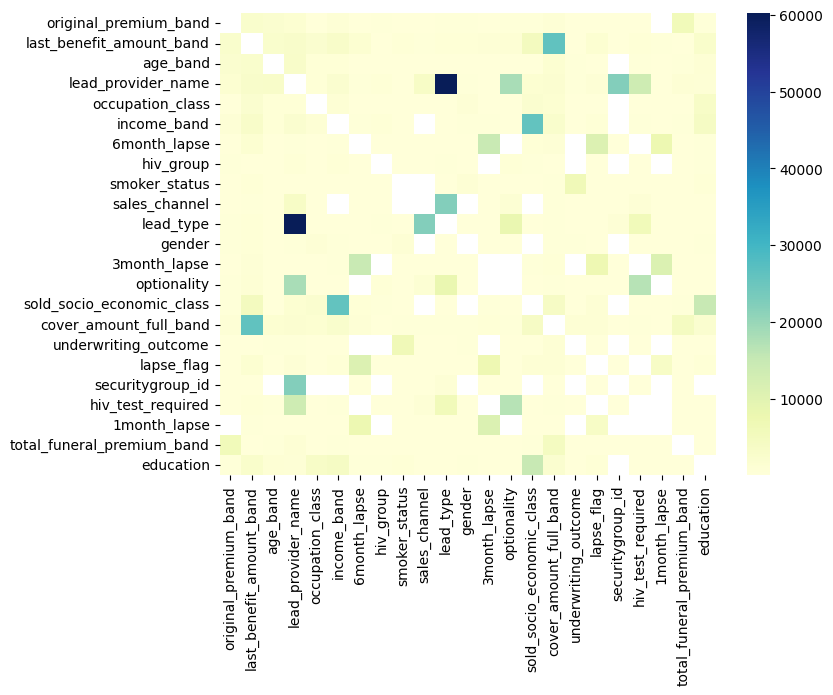

In [68]:
num_cols=[ '# calls contacted',
       'duration_policy_start_delay', 'res_code_sale_sum', 'eml',
       'res_code_no interest_sum', 'res_code_other_sum', 'res_code_claims_sum',
       'res_code_update_sum', 'pml', 'funeral_count', 'benefits_count',
       'res_code_QA_sum', '# calls', 'unemployment rate',
       'res_code_payment_sum', 'res_code_quote_sum', 'inflation']
cat_cols=['original_premium_band', 'last_benefit_amount_band', 'age_band',
       'lead_provider_name', 'occupation_class', 'income_band', '6month_lapse',
       'hiv_group', 'smoker_status', 'sales_channel', 'lead_type', 'gender',
       '3month_lapse', 'optionality', 'sold_socio_economic_class',
       'cover_amount_full_band', 'underwriting_outcome', 'lapse_flag',
       'securitygroup_id', 'hiv_test_required', '1month_lapse',
       'total_funeral_premium_band', 'education']

cat_plot=inception_analysis.significant_corr.loc[cat_cols,cat_cols].applymap(
    lambda x: np.nan if (isinstance(x, float) and pd.isnull(x)) 
    else (np.nan if not isinstance(x, (list, np.ndarray)) 
          else (x[0] if len(x) > 0 else np.nan)))
np.fill_diagonal(cat_plot.values, np.nan)
plt.figure(figsize=(8, 6))
sns.heatmap(cat_plot, cmap="YlGnBu")
plt.show()

C:\Users\E1005279\AppData\Local\Temp\ipykernel_22536\3652909070.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cat_num_plot=inception_analysis.significant_corr.loc[cat_cols,num_cols].applymap(


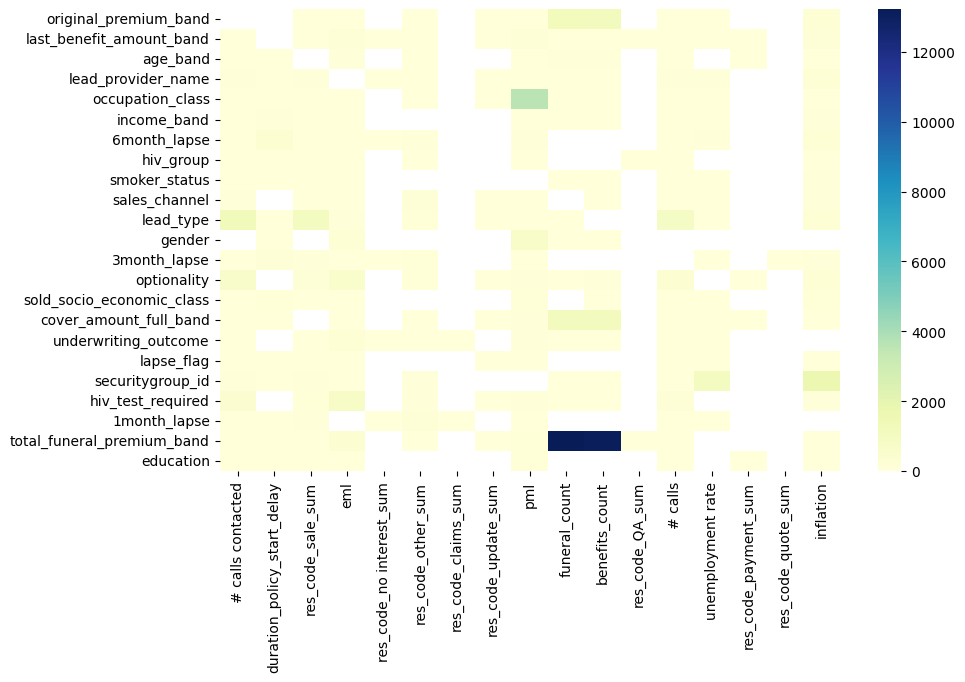

In [69]:
cat_num_plot=inception_analysis.significant_corr.loc[cat_cols,num_cols].applymap(
    lambda x: np.nan if (isinstance(x, float) and pd.isnull(x)) 
    else (np.nan if not isinstance(x, (list, np.ndarray)) 
          else (x[0] if len(x) > 0 else np.nan)))
np.fill_diagonal(cat_num_plot.values, np.nan)
plt.figure(figsize=(10, 6))
sns.heatmap(cat_num_plot, cmap="YlGnBu")
plt.show()

C:\Users\E1005279\AppData\Local\Temp\ipykernel_22536\3052170259.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_plot=inception_analysis.significant_corr.loc[num_cols,num_cols].applymap(


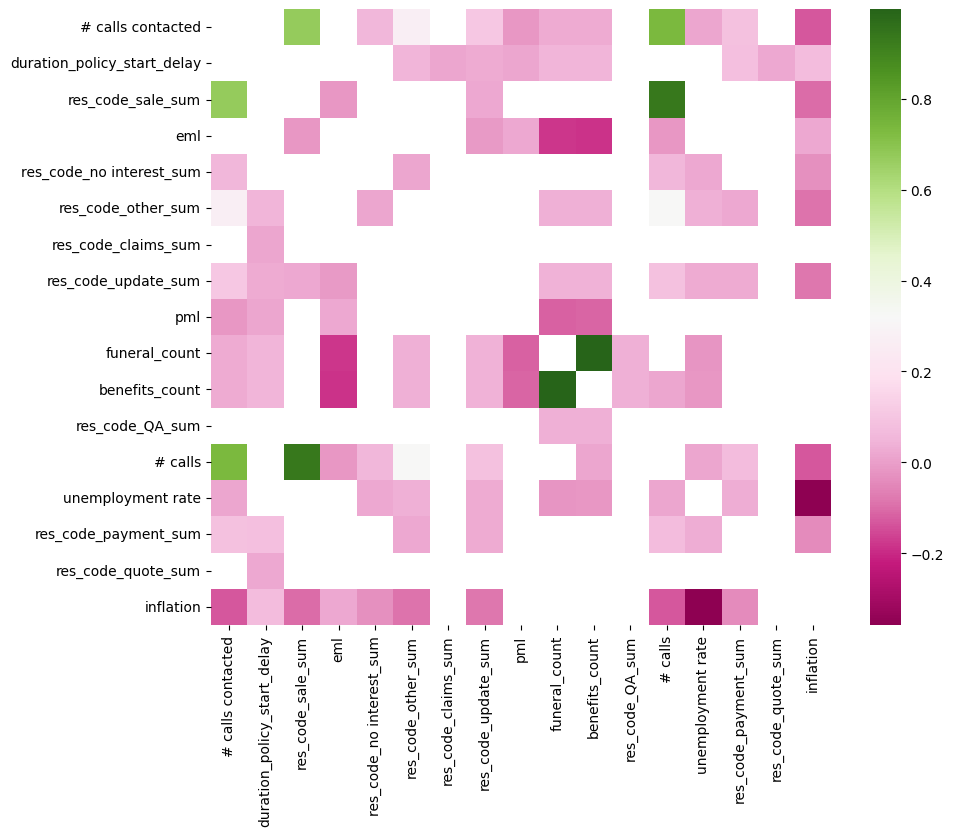

In [70]:
num_plot=inception_analysis.significant_corr.loc[num_cols,num_cols].applymap(
    lambda x: (np.nan if pd.isnull(x) else x) if (isinstance(x, float)) 
    else (np.nan if not isinstance(x, (list, np.ndarray)) 
          else (x[0] if len(x) > 0 else np.nan)))
np.fill_diagonal(num_plot.values, np.nan)
plt.figure(figsize=(10, 8))
sns.heatmap(num_plot, cmap="PiYG")
plt.show()

In [56]:
inception_analysis.significant_corr.loc[[
       'res_code_payment_sum'],['duration_policy_start_delay']]

,duration_policy_start_delay,duration_policy_start_delay
res_code_payment_sum,42.895885,0.0


### Plots

Number of NaN values to be dropped:  0


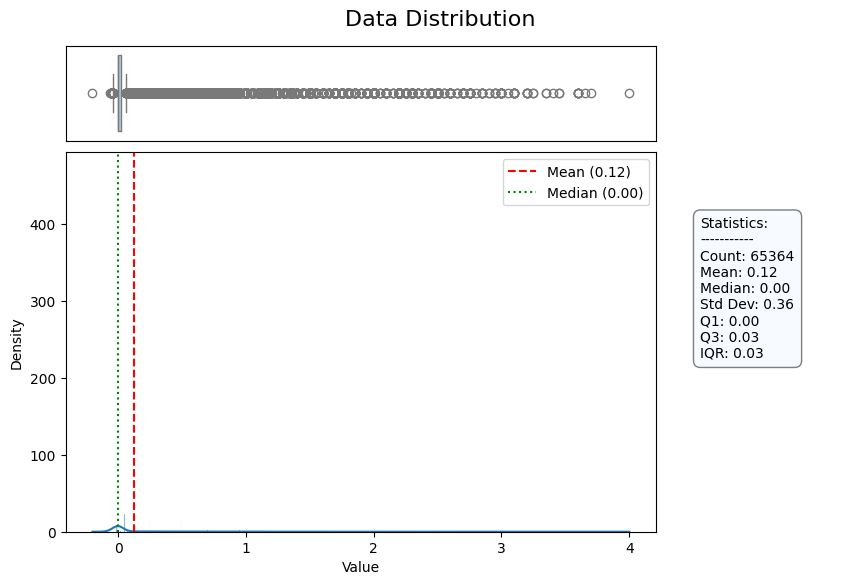

In [113]:
#plot_histogram_boxplot_kde(data, title="Distribution", x_label="value")
plot_histogram_boxplot_kde(at_inception.df[ 'eml'])

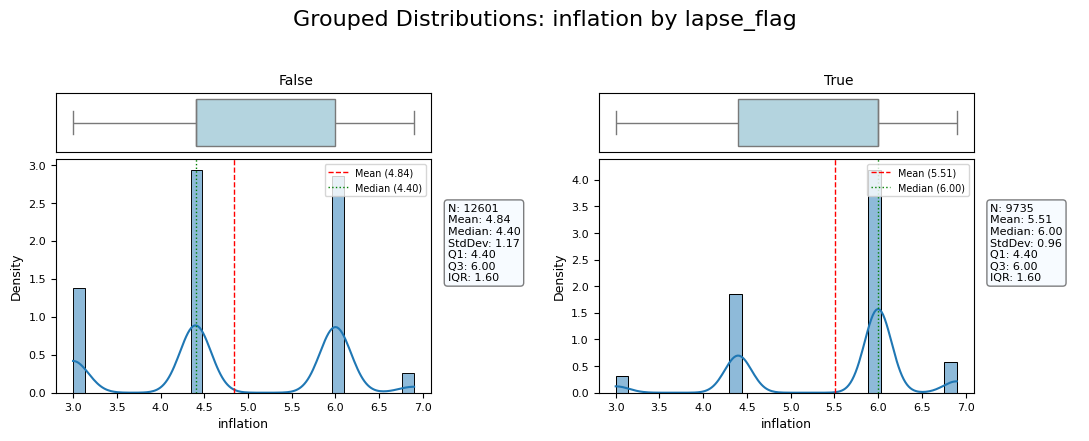

In [77]:
#plot_grouped_distributions(df, value_col, category_col='none',cat_list = [], main_title="Grouped Distributions")

#[ 'age' 'income',
#        'orginal individual_income', 'partner_income',
#       , 'eml', 'pml',  'benefits_count',
#       'last_benefit_amount', 'cover_amount_full', 'total_funeral_premium',
#       'funeral_count', 'original_premium', 
#       'duration_policy_start_delay', '# calls', '# calls contacted',
#       'res_code_QA_sum', 'res_code_claims_sum', 'res_code_no interest_sum',
#       'res_code_other_sum', 'res_code_payment_sum', 'res_code_quote_sum',
#       'res_code_sale_sum', 'res_code_update_sum', 'lapse_flag',
#       'expected_lapse_rate',
#'Month', 'Year', 'Day',
#       'Hour']

value_col ='inflation'
catgory_col='lapse_flag'
plot_grouped_distributions(at_inception.df, value_col, category_col=catgory_col,cat_list = [], main_title="Grouped Distributions")

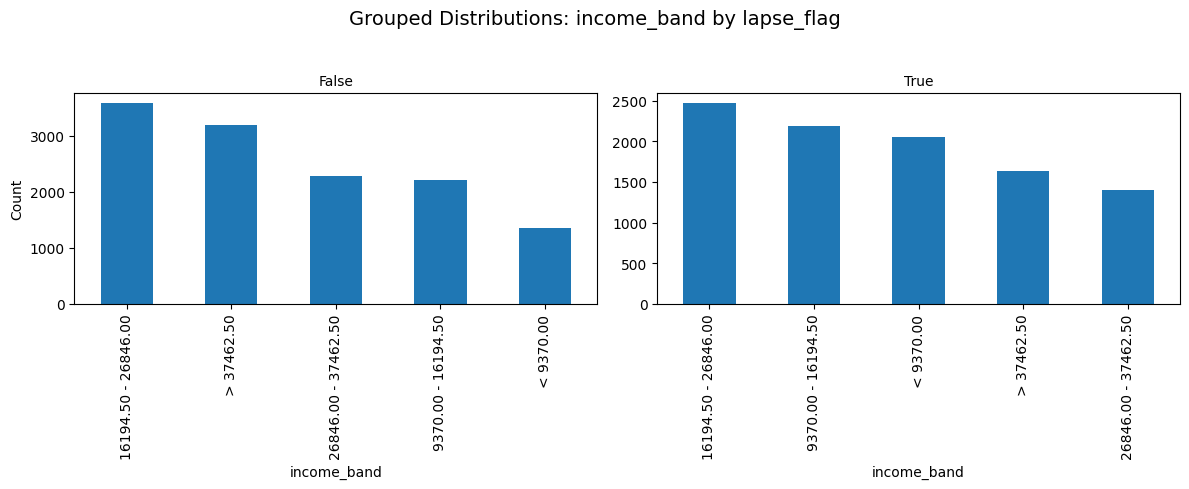

In [72]:
#['education', 'gender',
#       'smoker_status', 'sold_socio_economic_class', 'occupation_class',
#       
#       'lead_provider_name', 'lead_type', 'sales_channel', 
#       'campaign_name', 'underwriting_outcome', 'optionality',
#       'hiv_test_required', 'pricing_version','hiv_group',
#       'securitygroup_id', 'policy_type', 'fixed_debit_day',
#        'Month', 'Year', 'Day',
#       'Hour']
value_col=    'income_band'
category_col='lapse_flag'
categorical_bar_plot(at_inception.df, value_col, category_col=category_col,cat_list = [], main_title="Grouped Distributions")

## Near future lapse data

In [36]:
near_f = DataPreparation(df=near_ftr_lapse_data)
near_f.null_df

,nulls,percentage nulls
policy_id,0,0.000000
policy_name,0,0.000000
age,0,0.000000
education,0,0.000000
gender,0,0.000000
...,...,...
cancellation_effective_date,48714,76.138229
cancellation_reason,51680,80.773980
lapse_flag,0,0.000000
expected_lapse_rate,60,0.093778


In [35]:
#filling out some missing data with 0 and removing column
near_f.df[['total_funeral_premium','funeral_count','res_code_update_sum','res_code_sale_sum','res_code_payment_sum','res_code_other_sum','res_code_claims_sum',
                       'res_code_QA_sum','# calls contacted']]=near_f.df[['total_funeral_premium','funeral_count','res_code_update_sum','res_code_sale_sum','res_code_payment_sum','res_code_other_sum','res_code_claims_sum',
                       'res_code_QA_sum','# calls contacted']].fillna(0)


In [37]:
near_f.uniq_df

,no. of unique entries
policy_id,63981
policy_name,63981
age,48
education,8
gender,2
...,...
cancellation_effective_date,36
cancellation_reason,23
lapse_flag,2
expected_lapse_rate,2681


In [38]:
near_f.df.columns

Index(['policy_id', 'policy_name', 'age', 'education', 'gender', 'income',
       'current individual_income', 'orginal individual_income',
       'partner_income', 'occupation', 'occupation_class', 'smoker_status',
       'sold_socio_economic_class', 'lead_provider_name', 'lead_type',
       'sales_channel', 'campaign_name', '# calls', '# calls contacted',
       'res_code_QA_sum', 'res_code_claims_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_sale_sum', 'res_code_update_sum',
       'securitygroup_id', 'benefits_count', 'policy_type', 'original_premium',
       'premium', 'last_main_premium', 'prev_premium',
       'last premium amount due', '* policy start delay months',
       '* policy duration months', 'duration to anniversary',
       'cover_amount_full', 'last_benefit_amount', 'fixed_debit_day',
       'total_funeral_premium', 'funeral_count', '# anniversaries',
       'has_been_recaptured', 'reason', 'underwriting_outcome', 'optionality',
       'hiv_tes

In [22]:
near_f.df['underwriting_outcome'].unique()

array([nan, 'Accepted with Loadings', 'Accepted', 'Not Required',
       'Pending', 'Accidental Cover'], dtype=object)

In [41]:
near_f_analysis = Analysis(df=near_f.df, time_series='n', num_cols= ['age', 'income',
       'current individual_income', 'orginal individual_income',
       'partner_income',  '# calls', '# calls contacted',
       'res_code_QA_sum', 'res_code_claims_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_sale_sum', 'res_code_update_sum',
       'benefits_count','original_premium',
       'premium', 'last_main_premium', 'prev_premium',
       'last premium amount due', '* policy start delay months',
       '* policy duration months', 'duration to anniversary',
       'cover_amount_full', 'last_benefit_amount',
       'total_funeral_premium', 'funeral_count', '# anniversaries', 'eml', 'pml',
       'number_of_collection_attempts', 'number_of_successful_collections',
       'total_collected', 'net_collected', 'payment_method_DebiCheck_sum',
       'payment_method_EFT_sum', 'payment_method_Pre Fund_sum', 'payment rate',
       '# claims', 'expected_lapse_rate'],
         cat_cols=[ 'education', 'gender', 'occupation', 'occupation_class', 'smoker_status',
       'sold_socio_economic_class', 'lead_provider_name', 'lead_type',
       'sales_channel', 'campaign_name', 
       'securitygroup_id','policy_type', 'fixed_debit_day',
       'has_been_recaptured', 'reason', 'underwriting_outcome', 'optionality',
       'hiv_test_required', 'pricing_version', 'hiv_group',
       '1 month ago payment', '2 month ago payment', '3 month ago payment',
       '4 month ago payment', 'policy_status',
       'last_benefit_status', 'current_policy_status', 'lapse_type',
       'cancellation_reason', 'lapse_flag',
       ], date_col='cover_start_date')

In [25]:
near_f_analysis.num_stats

,Column,Distinct Count,Null Percentage,Mean,Median,Min,Max,Std Deviation,Mode,Quartile 25%,Quartile 75%
0,age,48,0.00,39.09,38.00,1.800000e+01,6.500000e+01,9.650000e+00,31.00,31.00,46.00
1,income,1717,0.00,893952.76,30000.00,1.700000e+01,2.767636e+10,1.546875e+08,40000.00,15000.00,40000.00
2,current individual_income,1717,0.00,893952.76,30000.00,1.700000e+01,2.767636e+10,1.546875e+08,40000.00,15000.00,40000.00
3,orginal individual_income,1717,0.00,893952.76,30000.00,1.700000e+01,2.767636e+10,1.546875e+08,40000.00,15000.00,40000.00
4,partner_income,852,0.00,-862032.29,0.00,-2.767635e+10,1.351100e+07,1.546876e+08,0.00,0.00,0.00
5,# calls,63,0.00,3.83,1.00,0.000000e+00,1.010000e+02,6.520000e+00,0.00,0.00,5.00
6,# calls contacted,23,0.00,0.93,0.00,0.000000e+00,3.000000e+01,1.690000e+00,0.00,0.00,1.00
7,res_code_QA_sum,4,0.00,0.00,0.00,0.000000e+00,4.000000e+00,2.000000e-02,0.00,0.00,0.00
8,res_code_claims_sum,11,0.00,0.00,0.00,0.000000e+00,1.500000e+01,1.300000e-01,0.00,0.00,0.00
9,res_code_other_sum,21,0.00,0.09,0.00,0.000000e+00,6.700000e+01,6.700000e-01,0.00,0.00,0.00


In [26]:
near_f_analysis .cat_stats

,Column,Distinct Count,Null Percentage,Most Frequent,Frequency Count,Frequency %
0,education,8,0.00,Matric,25034,39.13
1,gender,2,0.00,Female,32985,51.55
2,occupation,1401,66.67,Business Owner (10% - 20% travel and 21% - 50%...,1707,2.67
3,occupation_class,5,65.95,A,7975,12.46
4,smoker_status,3,1.61,N,49331,77.10
5,sold_socio_economic_class,4,0.00,1.0,28664,44.80
6,lead_provider_name,41,65.04,LeadWarming,3621,5.66
7,lead_type,7,65.04,Affiliate,10184,15.92
8,sales_channel,4,0.00,Agent,62341,97.44
9,campaign_name,121,0.00,MWL_TE_IN Migrated Policies 2023,23380,36.54


### Correlations

In [27]:
near_f_analysis.correlation_df

,2 month ago payment,securitygroup_id,lapse_flag,Hour,pricing_version,last_benefit_status,sold_socio_economic_class,sales_channel,campaign_name,education,...,# calls,# claims,res_code_sale_sum,last_main_premium,funeral_count,res_code_claims_sum,expected_lapse_rate,income,payment_method_Pre Fund_sum,res_code_QA_sum
2 month ago payment,"[48820.587669356, 0.0]","[0.0, 1.0]","[17143.730266609764, 0.0]","[0.0, 1.0]","[1582.7617623542126, 0.0]","[17259.90589491928, 0.0]","[1049.0165138734142, 4.185072008640555e-227]","[35.79683327035711, 1.6858402577093056e-08]","[1800.3802316932658, 0.0]","[652.9559481433105, 9.523663182048687e-137]",...,"[25520.03143497131, 0.0]","[0.07014061885556828, 0.7911332672457511]","[19694.194076339736, 0.0]","[28.30499754642422, 1.0408366359183763e-07]","[126.25992099854466, 2.930131997239686e-29]","[2.6839816121385582, 0.10136845248246039]","[2946.6296302747983, 0.0]","[0.2420173789353504, 0.6227550510362488]","[42.57085938532345, 6.883223748410231e-11]","[0.5898995098334905, 0.4424616947835436]"
securitygroup_id,"[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]",...,"[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]"
lapse_flag,"[17143.730266609764, 0.0]","[0.0, 1.0]","[48818.43180274677, 0.0]","[0.0, 1.0]","[2183.2903415995993, 0.0]","[47877.130902252175, 0.0]","[809.1663739517533, 4.4488639759443e-175]","[53.14465547645973, 2.882602055386252e-12]","[1909.3723747721012, 0.0]","[400.0800841236821, 2.292788321092754e-82]",...,"[0.3581578961173982, 0.0]","[0.02490750836646425, 3.70252461054969e-08]","[0.3700793712063486, 0.0]","[-0.03409056578759492, 4.8858832544019844e-14]","[0.013241489932039172, 0.003433474163047859]","[0.009935887697735764, 0.028126717081350158]","[0.25992072812303496, 0.0]","[-0.0017963399836547018, 0.6914232156613843]","[0.007222542742739984, 0.11050372672484383]","[-0.0028039232169192988, 0.5355451582886783]"
Hour,"[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]",...,"[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]"
pricing_version,"[1582.7617623542126, 0.0]","[0.0, 1.0]","[2183.2903415995993, 0.0]","[0.0, 1.0]","[244135.0, 0.0]","[2220.252144369572, 0.0]","[2318.5155760979465, 0.0]","[3566.470811019906, 0.0]","[155788.97191960018, 0.0]","[4150.142371389916, 0.0]",...,"[321.28097651574416, 0.0]","[6.538555202295566, 4.350450526684556e-06]","[268.4604364118146, 3.611924750067037e-284]","[100.95971822474594, 2.646121597714253e-106]","[117.3696738814432, 7.932016226958856e-124]","[6.187559333362124, 9.674735698468088e-06]","[71335.51457396332, 0.0]","[6.9728499558765105, 1.609871119816092e-06]","[3.104388853942318, 0.008357033564370979]","[3.717745444313101, 0.002295166501293741]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
res_code_claims_sum,"[2.6839816121385582, 0.10136845248246039]","[nan, nan]","[0.009935887697735764, 0.028126717081350158]","[nan, nan]","[6.187559333362124, 9.674735698468088e-06]","[7.7604676690467285, 3.0148154667958644e-06]","[4.457977997103016, 0.0038970179545722195]","[0.028146476658152127, 0.9722459608096208]","[4.757746733769441, 1.3845611103305128e-38]","[1.6386402324712759, 0.11940192560681016]",...,"[0.011255266418876853, 0.012879916617944433]","[0.03982999511624917, 1.3151285290728383e-18]","[0.004426680471379086, 0.32800710799461574]","[0.001462143893698433, 0.7466351211986972]","[0.005557211253204376, 0.21946735334818424]","[1.0, 0.0]","[0.01844486678731519, 4.5822206076596755e-05]","[-6.707723952300829e-05, 0.9881745345096153]","[-0.0005835625963479902, 0.8974007271986308]","[-0.00010320949976259748, 0.9818054636045304]"
expected_lapse_rate,"[2946.6296302747983, 0.0]","[nan, nan]","[0.25992072812

In [28]:
near_f_analysis.significant_corr

,2 month ago payment,securitygroup_id,lapse_flag,Hour,pricing_version,last_benefit_status,sold_socio_economic_class,sales_channel,campaign_name,education,...,# calls,# claims,res_code_sale_sum,last_main_premium,funeral_count,res_code_claims_sum,expected_lapse_rate,income,payment_method_Pre Fund_sum,res_code_QA_sum
2 month ago payment,"[48820.587669356, 0.0]",NaN,"[17143.730266609764, 0.0]",NaN,"[1582.7617623542126, 0.0]","[17259.90589491928, 0.0]","[1049.0165138734142, 4.185072008640555e-227]","[35.79683327035711, 1.6858402577093056e-08]","[1800.3802316932658, 0.0]","[652.9559481433105, 9.523663182048687e-137]",...,"[25520.03143497131, 0.0]",NaN,"[19694.194076339736, 0.0]","[28.30499754642422, 1.0408366359183763e-07]","[126.25992099854466, 2.930131997239686e-29]",NaN,"[2946.6296302747983, 0.0]",NaN,"[42.57085938532345, 6.883223748410231e-11]",NaN
securitygroup_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lapse_flag,"[17143.730266609764, 0.0]",NaN,"[48818.43180274677, 0.0]",NaN,"[2183.2903415995993, 0.0]","[47877.130902252175, 0.0]","[809.1663739517533, 4.4488639759443e-175]","[53.14465547645973, 2.882602055386252e-12]","[1909.3723747721012, 0.0]","[400.0800841236821, 2.292788321092754e-82]",...,"[0.3581578961173982, 0.0]","[0.02490750836646425, 3.70252461054969e-08]","[0.3700793712063486, 0.0]","[-0.03409056578759492, 4.8858832544019844e-14]","[0.013241489932039172, 0.003433474163047859]","[0.009935887697735764, 0.028126717081350158]","[0.25992072812303496, 0.0]",NaN,NaN,NaN
Hour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pricing_version,"[1582.7617623542126, 0.0]",NaN,"[2183.2903415995993, 0.0]",NaN,"[244135.0, 0.0]","[2220.252144369572, 0.0]","[2318.5155760979465, 0.0]","[3566.470811019906, 0.0]","[155788.97191960018, 0.0]","[4150.142371389916, 0.0]",...,"[321.28097651574416, 0.0]","[6.538555202295566, 4.350450526684556e-06]","[268.4604364118146, 3.611924750067037e-284]","[100.95971822474594, 2.646121597714253e-106]","[117.3696738814432, 7.932016226958856e-124]","[6.187559333362124, 9.674735698468088e-06]","[71335.51457396332, 0.0]","[6.9728499558765105, 1.609871119816092e-06]","[3.104388853942318, 0.008357033564370979]","[3.717745444313101, 0.002295166501293741]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
res_code_claims_sum,NaN,NaN,"[0.009935887697735764, 0.028126717081350158]",NaN,"[6.187559333362124, 9.674735698468088e-06]","[7.7604676690467285, 3.0148154667958644e-06]","[4.457977997103016, 0.0038970179545722195]",NaN,"[4.757746733769441, 1.3845611103305128e-38]",NaN,...,"[0.011255266418876853, 0.012879916617944433]","[0.03982999511624917, 1.3151285290728383e-18]",NaN,NaN,NaN,"[1.0, 0.0]","[0.01844486678731519, 4.5822206076596755e-05]",NaN,NaN,NaN
expected_lapse_rate,"[2946.6296302747983, 0.0]",NaN,"[0.25992072812303496, 0.0]",NaN,"[71335.51457396332, 0.0]","[893.7872665647824, 0.0]","[525.7920071559097, 0.0]","[533.3702586795674, 7.15298597357387e-230]","[4432.60812663737, 0.0]","[505.5757584947503, 0.0]",...,"[0.19746316435233632, 0.0]",NaN,"[0.18196103511119702, 0.0]","[-0.023620397007389757, 1.7896747023890072e-07]","[0.08894207057745168, 2.5296122895392973e-86]","[0.01844486678731519, 4.5822206076596755e-05]","[1.0, 0.0]","[0.011280865967823609, 0.012676536683022864]",NaN,"[0.011249055075299393, 0.012929696800790253]"
income,NaN,NaN,NaN,NaN,"[6.9728499558765105, 1.609871119816092e-06]",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[0.011280865967823609, 0.012676536683022864]","[0.9999999999999991, 0.0]",NaN,NaN
payment_method_Pre Fund_sum,"[42.57085938532345, 6.883223748410231e-11]",NaN,NaN,NaN,"[3.104388853942318, 0.008357033564370979]",NaN,"[5.417917956051763, 0.0010071221473612988]",NaN,NaN,"[4.975927844214343, 1.2085599867324042e-05]",...,"[0.040958533268563, 1.376911784363942e-19]",NaN,"[0.03910351730664757, 5.4410285100785475e-18]",NaN,NaN,NaN,NaN,NaN,"[0.9999999999999998, 0.0]",Na

C:\Users\E1005279\AppData\Local\Temp\ipykernel_29592\761246179.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ]].applymap(


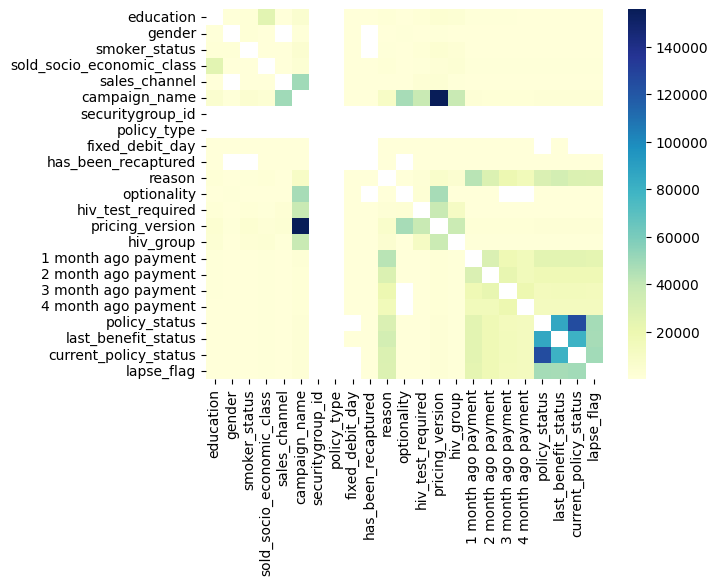

In [ ]:
# columns dropped by imputation function (too many nulls)['occupation', 'occupation_class', 'lead_provider_name', 'lead_type', 'underwriting_outcome', 'lapse_type', 'cancellation_reason']
cat_plot=near_f_analysis.significant_corr.loc[[ 'education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 
       'sales_channel', 'campaign_name', 
       'securitygroup_id','policy_type', 'fixed_debit_day',
       'has_been_recaptured', 'reason',  'optionality',
       'hiv_test_required', 'pricing_version', 'hiv_group',
       '1 month ago payment', '2 month ago payment', '3 month ago payment',
       '4 month ago payment', 'policy_status',
       'last_benefit_status', 'current_policy_status', 'lapse_flag',
       ]
       ,[ 'education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 
       'sales_channel', 'campaign_name', 
       'securitygroup_id','policy_type', 'fixed_debit_day',
       'has_been_recaptured', 'reason',  'optionality',
       'hiv_test_required', 'pricing_version', 'hiv_group',
       '1 month ago payment', '2 month ago payment', '3 month ago payment',
       '4 month ago payment', 'policy_status',
       'last_benefit_status', 'current_policy_status', 'lapse_flag',
       ]].applymap(
    lambda x: np.nan if (isinstance(x, float) and pd.isnull(x)) 
    else (np.nan if not isinstance(x, (list, np.ndarray)) 
          else (x[0] if len(x) > 0 else np.nan)))
np.fill_diagonal(cat_plot.values, np.nan)
plt.figure(figsize=(12, 6))
sns.heatmap(cat_plot, cmap="YlGnBu")
plt.show()

C:\Users\E1005279\AppData\Local\Temp\ipykernel_29592\334073808.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  '# claims', 'expected_lapse_rate']].applymap(


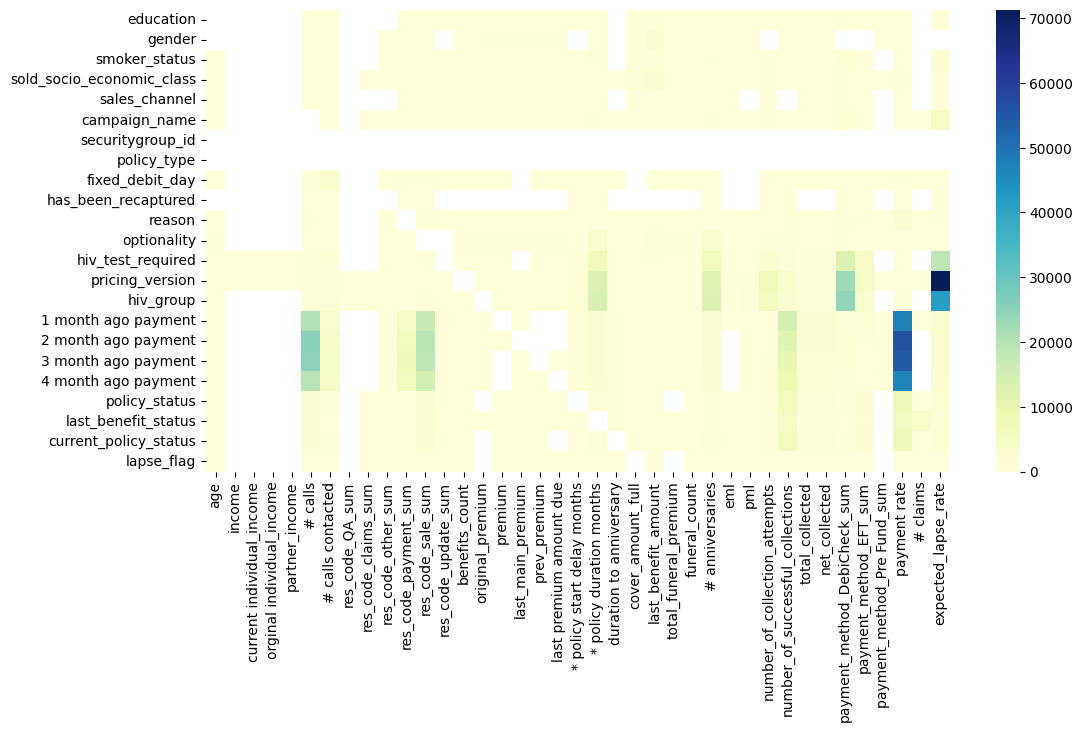

In [34]:
cat_num_plot=near_f_analysis.significant_corr.loc[[ 'education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 
       'sales_channel', 'campaign_name', 
       'securitygroup_id','policy_type', 'fixed_debit_day',
       'has_been_recaptured', 'reason',  'optionality',
       'hiv_test_required', 'pricing_version', 'hiv_group',
       '1 month ago payment', '2 month ago payment', '3 month ago payment',
       '4 month ago payment', 'policy_status',
       'last_benefit_status', 'current_policy_status', 'lapse_flag',
       ]
       ,['age', 'income',
       'current individual_income', 'orginal individual_income',
       'partner_income',  '# calls', '# calls contacted',
       'res_code_QA_sum', 'res_code_claims_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_sale_sum', 'res_code_update_sum',
       'benefits_count','original_premium',
       'premium', 'last_main_premium', 'prev_premium',
       'last premium amount due', '* policy start delay months',
       '* policy duration months', 'duration to anniversary',
       'cover_amount_full', 'last_benefit_amount',
       'total_funeral_premium', 'funeral_count', '# anniversaries', 'eml', 'pml',
       'number_of_collection_attempts', 'number_of_successful_collections',
       'total_collected', 'net_collected', 'payment_method_DebiCheck_sum',
       'payment_method_EFT_sum', 'payment_method_Pre Fund_sum', 'payment rate',
       '# claims', 'expected_lapse_rate']].applymap(
    lambda x: np.nan if (isinstance(x, float) and pd.isnull(x)) 
    else (np.nan if not isinstance(x, (list, np.ndarray)) 
          else (x[0] if len(x) > 0 else np.nan)))
np.fill_diagonal(cat_num_plot.values, np.nan)
plt.figure(figsize=(12, 6))
sns.heatmap(cat_num_plot, cmap="YlGnBu")
plt.show()

C:\Users\E1005279\AppData\Local\Temp\ipykernel_29592\1522323493.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  '# claims', 'expected_lapse_rate']].applymap(


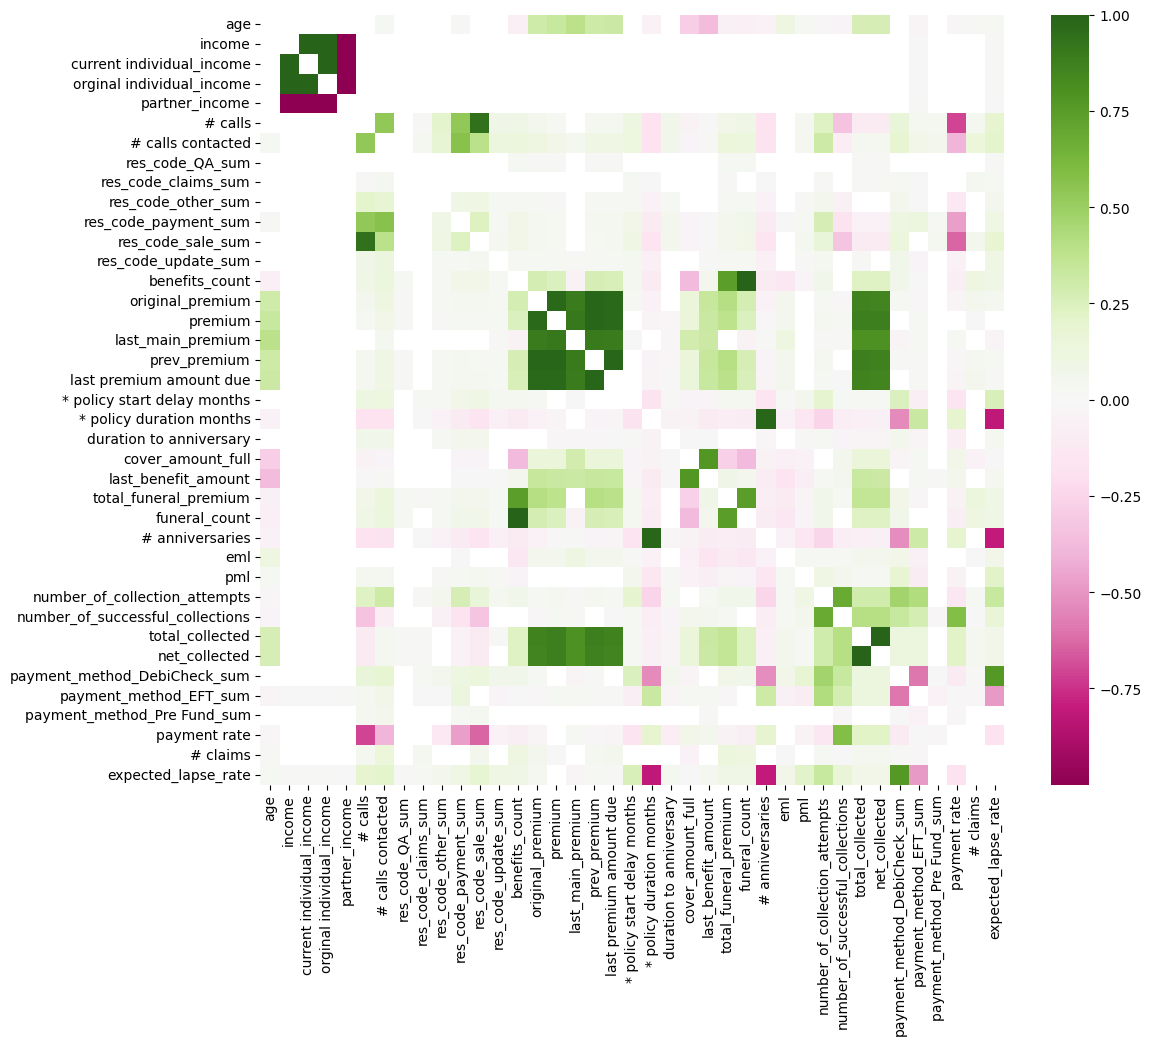

In [38]:
num_plot=near_f_analysis.significant_corr.loc[['age', 'income',
       'current individual_income', 'orginal individual_income',
       'partner_income',  '# calls', '# calls contacted',
       'res_code_QA_sum', 'res_code_claims_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_sale_sum', 'res_code_update_sum',
       'benefits_count','original_premium',
       'premium', 'last_main_premium', 'prev_premium',
       'last premium amount due', '* policy start delay months',
       '* policy duration months', 'duration to anniversary',
       'cover_amount_full', 'last_benefit_amount',
       'total_funeral_premium', 'funeral_count', '# anniversaries', 'eml', 'pml',
       'number_of_collection_attempts', 'number_of_successful_collections',
       'total_collected', 'net_collected', 'payment_method_DebiCheck_sum',
       'payment_method_EFT_sum', 'payment_method_Pre Fund_sum', 'payment rate',
       '# claims', 'expected_lapse_rate'],['age', 'income',
       'current individual_income', 'orginal individual_income',
       'partner_income',  '# calls', '# calls contacted',
       'res_code_QA_sum', 'res_code_claims_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_sale_sum', 'res_code_update_sum',
       'benefits_count','original_premium',
       'premium', 'last_main_premium', 'prev_premium',
       'last premium amount due', '* policy start delay months',
       '* policy duration months', 'duration to anniversary',
       'cover_amount_full', 'last_benefit_amount',
       'total_funeral_premium', 'funeral_count', '# anniversaries', 'eml', 'pml',
       'number_of_collection_attempts', 'number_of_successful_collections',
       'total_collected', 'net_collected', 'payment_method_DebiCheck_sum',
       'payment_method_EFT_sum', 'payment_method_Pre Fund_sum', 'payment rate',
       '# claims', 'expected_lapse_rate']].applymap(
    lambda x: (np.nan if pd.isnull(x) else x) if (isinstance(x, float)) 
    else (np.nan if not isinstance(x, (list, np.ndarray)) 
          else (x[0] if len(x) > 0 else np.nan)))
np.fill_diagonal(num_plot.values, np.nan)
plt.figure(figsize=(12, 10))
sns.heatmap(num_plot, cmap="PiYG")
plt.show()

### plots

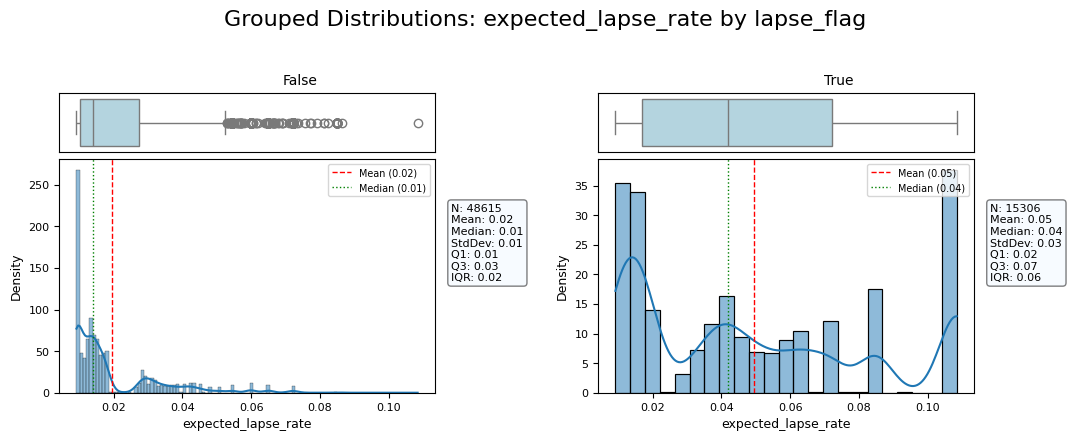

In [ ]:
#num_cols= ['age'# 'income'#'current individual_income'# 'orginal individual_income'#'partner_income'#  '# calls'# '# calls contacted'#'res_code_QA_sum'# 'res_code_claims_sum'# 'res_code_other_sum'#  'res_code_payment_sum'# 'res_code_sale_sum'# 'res_code_update_sum'#'benefits_count'#'original_premium'#'premium'# 'last_main_premium'# 'prev_premium'# 'last premium amount due'# '* policy start delay months'# '* policy duration months'# 'duration to anniversary'#'cover_amount_full'# 'last_benefit_amount'#'total_funeral_premium'# 'funeral_count'# '# anniversaries'# 'eml'# 'pml'#'number_of_collection_attempts'# 'number_of_successful_collections'# 'total_collected'# 'net_collected'# 'payment_method_DebiCheck_sum'#'payment_method_EFT_sum'# 'payment_method_Pre Fund_sum'# 'payment rate'#'# claims'# 'expected_lapse_rate'],

value_col =  'expected_lapse_rate'
catgory_col='lapse_flag'
plot_grouped_distributions(near_f.df, value_col, category_col=catgory_col,cat_list = [], main_title="Grouped Distributions")

In [80]:
at_inception.df.columns

Index(['policy_id', 'policy_name', 'age', 'education', 'gender', 'income',
       'smoker_status', 'sold_socio_economic_class', 'occupation_class',
       'occupation', 'orginal individual_income', 'partner_income',
       'lead_provider_name', 'lead_type', 'sales_channel', 'sale_date',
       'campaign_name', 'underwriting_outcome', 'optionality',
       'hiv_test_required', 'pricing_version', 'eml', 'pml', 'hiv_group',
       'securitygroup_id', 'policy_type', 'benefits_count',
       'last_benefit_amount', 'cover_amount_full', 'total_funeral_premium',
       'funeral_count', 'original_premium', 'fixed_debit_day',
       'duration_policy_start_delay', '# calls', '# calls contacted',
       'res_code_QA_sum', 'res_code_claims_sum', 'res_code_no interest_sum',
       'res_code_other_sum', 'res_code_payment_sum', 'res_code_quote_sum',
       'res_code_sale_sum', 'res_code_update_sum', 'policy_status',
       'current_policy_status', 'cancellation_effective_date',
       'cancellation_re

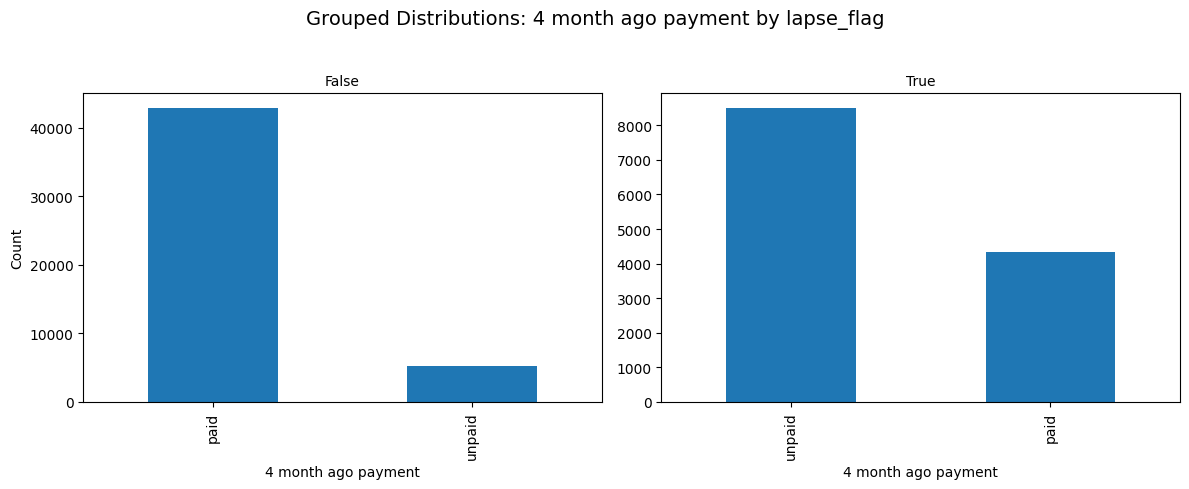

In [26]:
    #    cat_cols=[ 'education'# 'gender'# 'occupation'# 'occupation_class'# 'smoker_status'# 'sold_socio_economic_class'# 'lead_provider_name'# 'lead_type'# 'sales_channel'# 'campaign_name'# 'securitygroup_id'#'policy_type'# 'fixed_debit_day'# 'has_been_recaptured'# 'reason'# 'underwriting_outcome'# 'optionality'#'hiv_test_required'# 'pricing_version'# 'hiv_group'# '1 month ago payment'# '2 month ago payment'# '3 month ago payment'#'4 month ago payment'# 'policy_status'#'last_benefit_status'# 'current_policy_status'# 'lapse_type'#'cancellation_reason'# 'lapse_flag' ]

value_col=  '4 month ago payment'# 'policy_status'#'last_benefit_status'# 'current_policy_status'# 'lapse_type'#'cancellation_reason'# 'lapse_flag' ]
category_col='lapse_flag'
categorical_bar_plot(near_f.df, value_col, category_col=category_col,cat_list = [], main_title="Grouped Distributions")

In [106]:
"'age', 'income','current individual_income', 'orginal individual_income','partner_income',  '# calls', '# calls contacted','res_code_QA_sum', 'res_code_claims_sum', 'res_code_other_sum',  'res_code_payment_sum', 'res_code_sale_sum', 'res_code_update_sum','benefits_count','original_premium','premium', 'last_main_premium', 'prev_premium', 'last premium amount due', '* policy start delay months', '* policy duration months', 'duration to anniversary','cover_amount_full', 'last_benefit_amount','total_funeral_premium', 'funeral_count', '# anniversaries', 'eml', 'pml','number_of_collection_attempts', 'number_of_successful_collections', 'total_collected', 'net_collected', 'payment_method_DebiCheck_sum','payment_method_EFT_sum', 'payment_method_Pre Fund_sum', 'payment rate','# claims', 'expected_lapse_rate'".replace(',','#')

"'age'# 'income'#'current individual_income'# 'orginal individual_income'#'partner_income'#  '# calls'# '# calls contacted'#'res_code_QA_sum'# 'res_code_claims_sum'# 'res_code_other_sum'#  'res_code_payment_sum'# 'res_code_sale_sum'# 'res_code_update_sum'#'benefits_count'#'original_premium'#'premium'# 'last_main_premium'# 'prev_premium'# 'last premium amount due'# '* policy start delay months'# '* policy duration months'# 'duration to anniversary'#'cover_amount_full'# 'last_benefit_amount'#'total_funeral_premium'# 'funeral_count'# '# anniversaries'# 'eml'# 'pml'#'number_of_collection_attempts'# 'number_of_successful_collections'# 'total_collected'# 'net_collected'# 'payment_method_DebiCheck_sum'#'payment_method_EFT_sum'# 'payment_method_Pre Fund_sum'# 'payment rate'#'# claims'# 'expected_lapse_rate'"

# Investigations

In [16]:
inception_analysis.df[['pricing_version','campaign_name','Year','policy_id']].groupby(['pricing_version','campaign_name']).nunique()

Year  policy_id
pricing_version campaign_name                            
MWL_FCS_202403  MWLWebDefault                1         20
                MiFuneral-FBSocial           1          3
                MiFuneral-Facebook           2        228
                MiFuneral-GoogleSearch       2        370
                MiFuneral-LifeDeclined       1          1
...                                        ...        ...
SD_OUT_202505   SD-LifeCover-Olico           1         59
                SD-LifeCover-Olico-Meta      1         23
                SD-Referral                  1        116
                SDWebDefault                 1         17
                Sanlam-Lead-D365-Default     1          7

[237 rows x 2 columns]

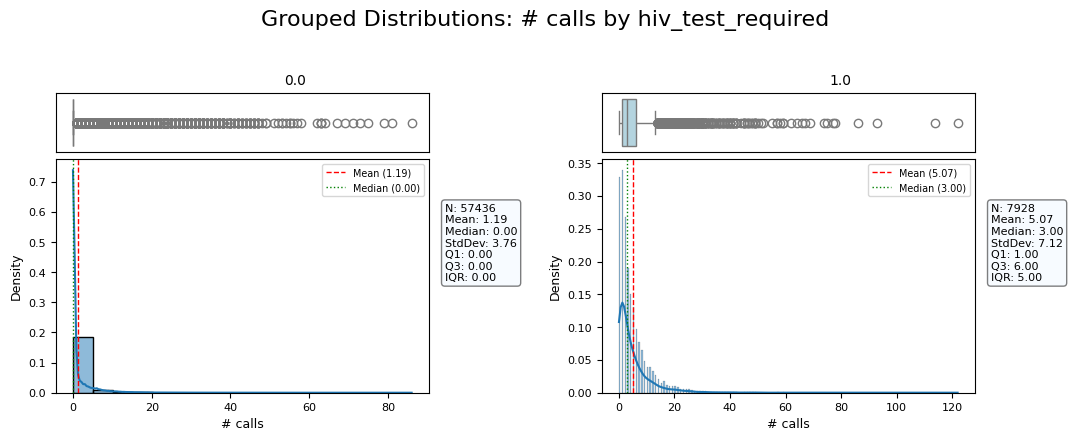

In [19]:

plot_grouped_distributions(inception_analysis.df,'# calls', category_col='hiv_test_required',cat_list = [], main_title="Grouped Distributions")



In [20]:
inception_analysis.df.columns

Index(['policy_id', 'policy_name', 'age', 'education', 'gender', 'income',
       'smoker_status', 'sold_socio_economic_class', 'occupation_class',
       'occupation', 'orginal individual_income', 'partner_income',
       'lead_provider_name', 'lead_type', 'sales_channel', 'sale_date',
       'campaign_name', 'underwriting_outcome', 'optionality',
       'hiv_test_required', 'pricing_version', 'eml', 'pml', 'hiv_group',
       'securitygroup_id', 'policy_type', 'benefits_count',
       'last_benefit_amount', 'cover_amount_full', 'total_funeral_premium',
       'funeral_count', 'original_premium', 'fixed_debit_day',
       'duration_policy_start_delay', '# calls', '# calls contacted',
       'res_code_QA_sum', 'res_code_claims_sum', 'res_code_no interest_sum',
       'res_code_other_sum', 'res_code_payment_sum', 'res_code_quote_sum',
       'res_code_sale_sum', 'res_code_update_sum', 'policy_status',
       'current_policy_status', 'cancellation_effective_date',
       'cancellation_re

In [33]:
call_1=inception_analysis.df[inception_analysis.df['hiv_test_required']==1][['# calls']].sum()
call_1[0]

C:\Users\E1005279\AppData\Local\Temp\ipykernel_18572\3819292457.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  call_1[0]


40181.0

In [34]:
pol_1=inception_analysis.df[inception_analysis.df['hiv_test_required']==1][['policy_id']].nunique()
pol_1[0]

C:\Users\E1005279\AppData\Local\Temp\ipykernel_18572\682669151.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pol_1[0]


7928

In [31]:
inception_analysis.df[inception_analysis.df['hiv_test_required']==1][['res_code_QA_sum', 'res_code_claims_sum', 'res_code_no interest_sum',
       'res_code_other_sum', 'res_code_payment_sum', 'res_code_quote_sum',
       'res_code_sale_sum', 'res_code_update_sum']].sum()*100/call_1[0]

C:\Users\E1005279\AppData\Local\Temp\ipykernel_18572\3936319780.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'res_code_sale_sum', 'res_code_update_sum']].sum()*100/call_1[0]


res_code_QA_sum              0.004977
res_code_claims_sum          0.004977
res_code_no interest_sum     0.238919
res_code_other_sum          19.661034
res_code_payment_sum         0.719245
res_code_quote_sum           0.000000
res_code_sale_sum           77.001568
res_code_update_sum          1.465867
dtype: float64

In [32]:
call_0=inception_analysis.df[inception_analysis.df['hiv_test_required']==0][['# calls']].sum()
call_0[0]

C:\Users\E1005279\AppData\Local\Temp\ipykernel_18572\1995773793.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  call_0[0]


68491.0

In [35]:
pol_0=inception_analysis.df[inception_analysis.df['hiv_test_required']==0][['policy_id']].nunique()
pol_0[0]

C:\Users\E1005279\AppData\Local\Temp\ipykernel_18572\3333353204.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pol_0[0]


57436

In [29]:
inception_analysis.df[inception_analysis.df['hiv_test_required']==0][['res_code_QA_sum', 'res_code_claims_sum', 'res_code_no interest_sum',
       'res_code_other_sum', 'res_code_payment_sum', 'res_code_quote_sum',
       'res_code_sale_sum', 'res_code_update_sum']].sum()*100/call_0[0]

C:\Users\E1005279\AppData\Local\Temp\ipykernel_18572\2863739931.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'res_code_sale_sum', 'res_code_update_sum']].sum()*100/call_0[0]


res_code_QA_sum              0.017521
res_code_claims_sum          0.004380
res_code_no interest_sum     0.302229
res_code_other_sum          25.302595
res_code_payment_sum         2.553620
res_code_quote_sum           0.004380
res_code_sale_sum           69.771211
res_code_update_sum          1.584150
dtype: float64

In [36]:
near_ftr_lapse_data.columns

Index(['Unnamed: 0', 'policy_id', 'policy_name', 'age', 'education', 'gender',
       'income', 'current individual_income', 'orginal individual_income',
       'partner_income', 'occupation', 'occupation_class', 'smoker_status',
       'sold_socio_economic_class', 'lead_provider_name', 'lead_type',
       'sales_channel', 'campaign_name', '# calls', '# calls contacted',
       'res_code_QA_sum', 'res_code_claims_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_sale_sum', 'res_code_update_sum',
       'securitygroup_id', 'benefits_count', 'policy_type', 'original_premium',
       'premium', 'last_main_premium', 'prev_premium',
       'last premium amount due', '* policy start delay months',
       '* policy duration months', 'duration to anniversary',
       'cover_amount_full', 'last_benefit_amount', 'fixed_debit_day',
       'total_funeral_premium', 'funeral_count', '# anniversaries',
       'has_been_recaptured', 'reason', 'underwriting_outcome', 'optionality',
 

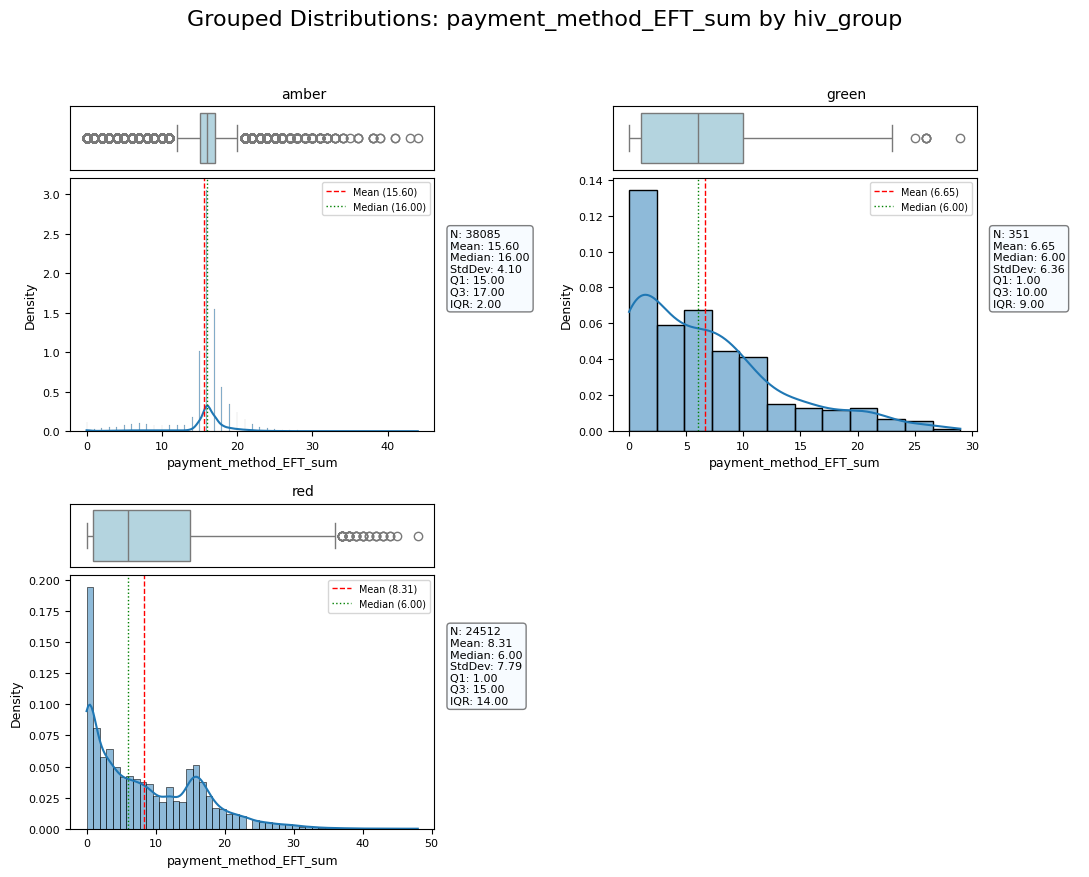

In [49]:
plot_grouped_distributions(near_ftr_lapse_data,'payment_method_EFT_sum', category_col='hiv_group',cat_list = [], main_title="Grouped Distributions")

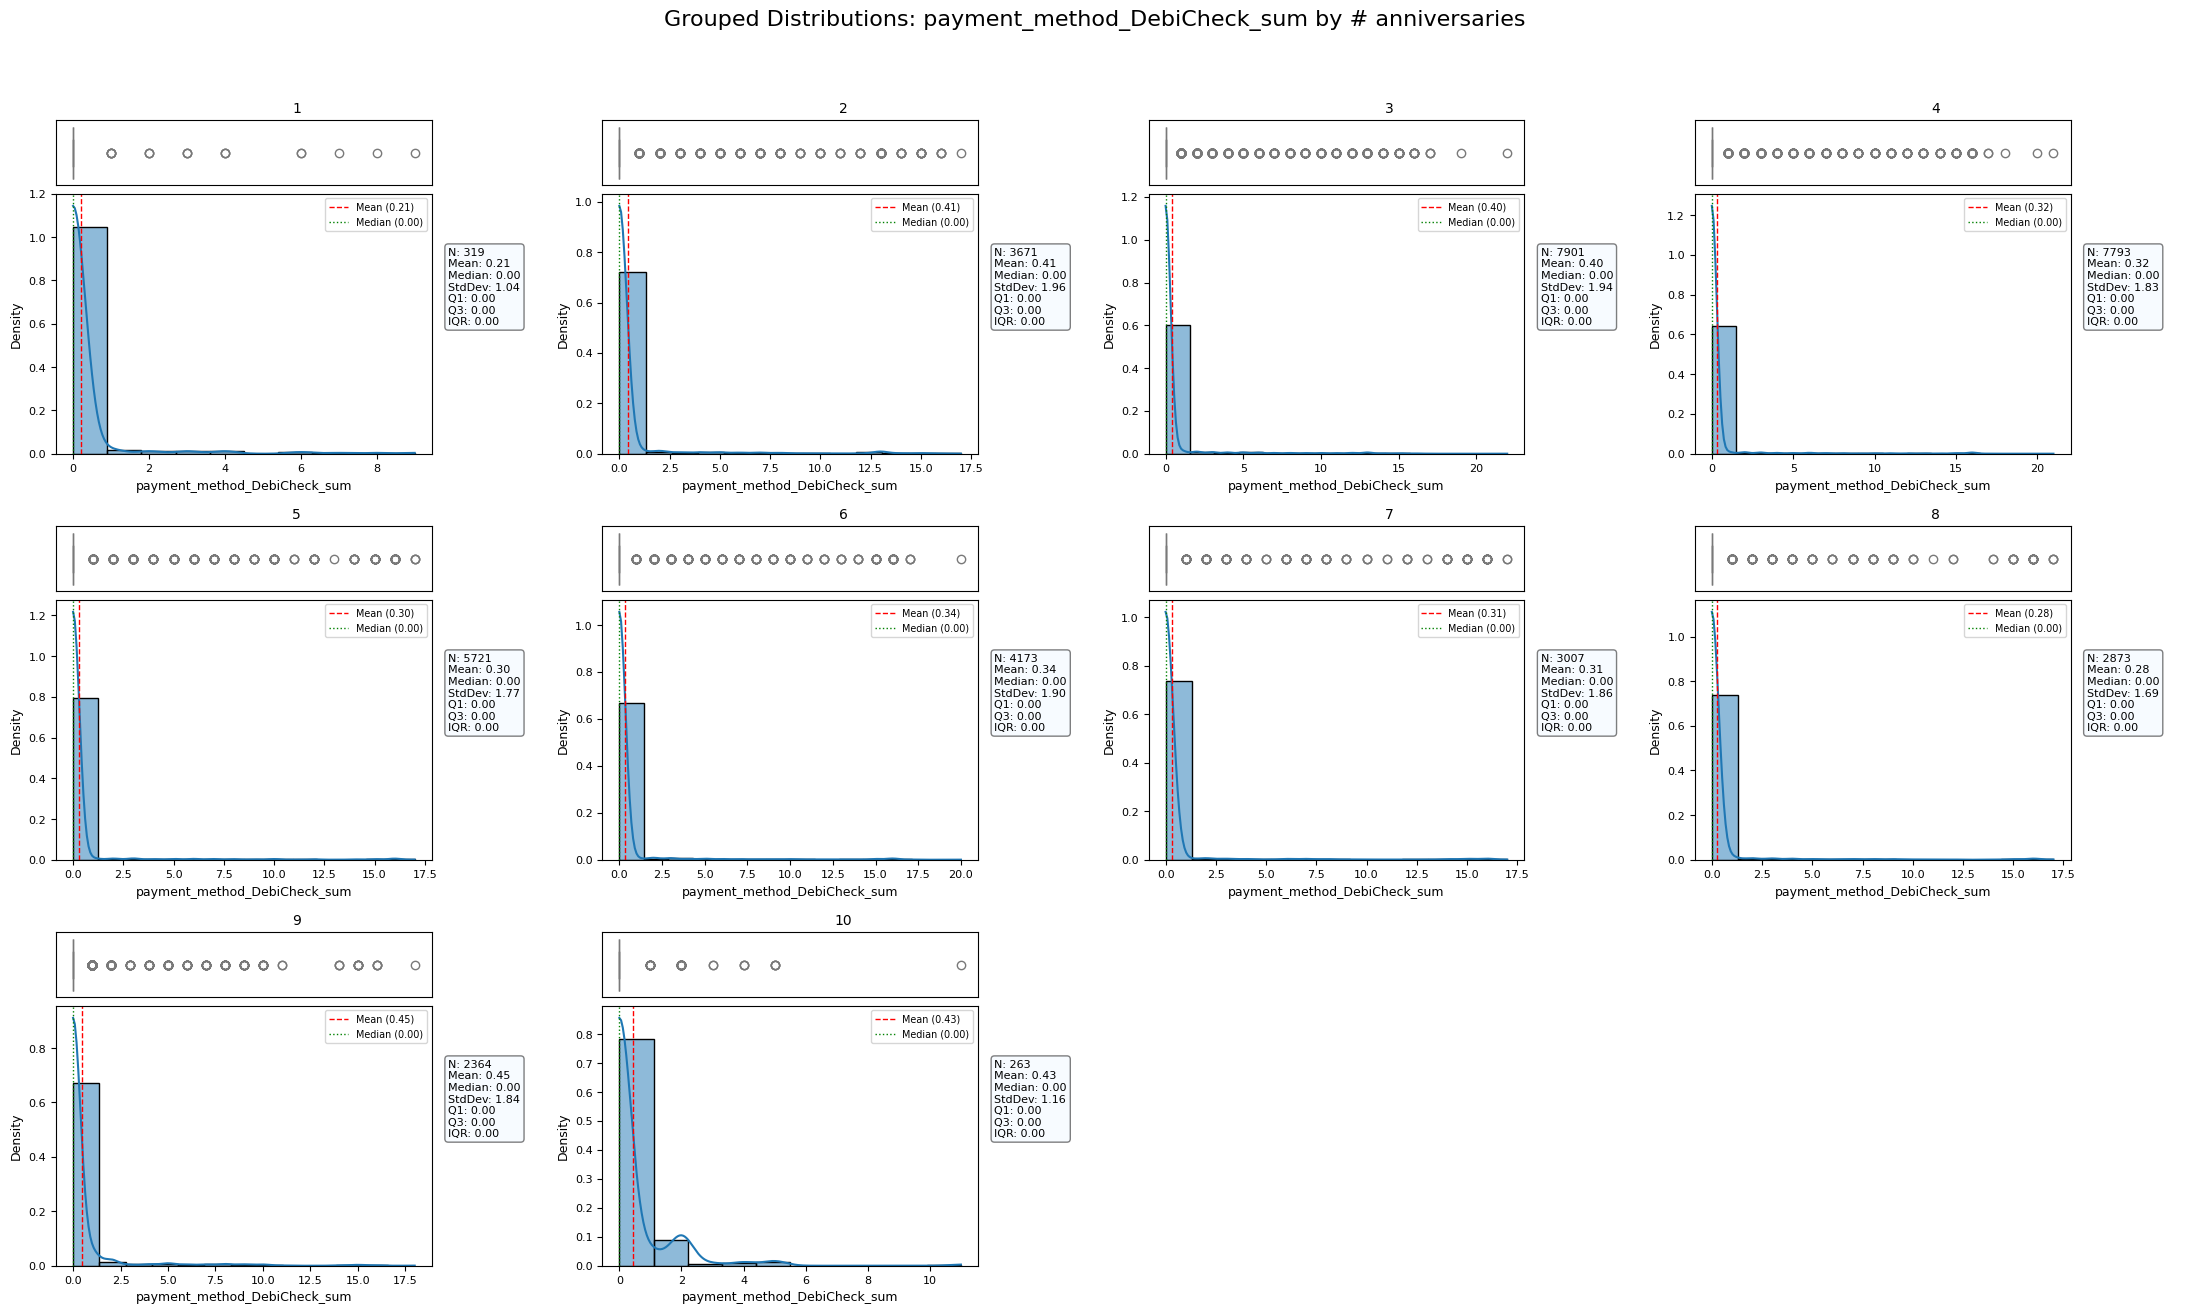

In [51]:
plot_grouped_distributions(near_f_analysis.df[near_f_analysis.df['hiv_group']=='amber'],'payment_method_DebiCheck_sum', category_col='# anniversaries',cat_list = [], main_title="Grouped Distributions")


In [52]:
near_f_analysis.df[near_f_analysis.df['hiv_group']=='amber'][['policy_id','payment_method_DebiCheck_sum']].groupby('payment_method_DebiCheck_sum').nunique()

,policy_id
payment_method_DebiCheck_sum,
0,35939
1,402
2,311
3,193
4,144
5,143
6,128
7,106
8,96


In [53]:
near_f_analysis.df[near_f_analysis.df['hiv_group']=='amber']['Year'].unique()

array([2021, 2022, 2020, 2016, 2018, 2017, 2019, 2015, 2023], dtype=object)

In [76]:
near_ftr_lapse_data[['securitygroup_id','policy_type','policy_id']].groupby(['securitygroup_id','policy_type']).nunique()

policy_id
securitygroup_id policy_type                  
MWL              Fully Underwritten      62888
                 Funeral Cover            1033
SD               Fully Underwritten         60

In [75]:
near_ftr_lapse_data[near_ftr_lapse_data['policy_type']=='Funeral Cover'][['lapse_flag','policy_type','policy_id']].groupby(['lapse_flag','policy_type']).nunique()

,,policy_id
lapse_flag,policy_type,
False,Funeral Cover,865
True,Funeral Cover,168


In [82]:
inception_analysis.df[inception_analysis.df['policy_type']=='Funeral Cover'][['lapse_flag','Year','policy_id']].groupby(['lapse_flag','Year']).nunique()

policy_id
lapse_flag Year           
False      2024        260
           2025        955
True       2024         93
           2025        104

In [83]:
inception_analysis.df[['lapse_flag','securitygroup_id','policy_id']].groupby(['lapse_flag','securitygroup_id']).nunique()

policy_id
lapse_flag securitygroup_id           
False      MWL                   49451
           SD                      454
True       MWL                   15397
           SD                       62

# Data transformations post-EDA

In [39]:
#filling out some missing data with 0 and removing column
near_ftr_lapse_data[['total_funeral_premium','funeral_count','res_code_update_sum','res_code_sale_sum','res_code_payment_sum','res_code_other_sum','res_code_claims_sum',
                       'res_code_QA_sum','# calls contacted']]=near_ftr_lapse_data[['total_funeral_premium','funeral_count','res_code_update_sum','res_code_sale_sum','res_code_payment_sum','res_code_other_sum','res_code_claims_sum',
                       'res_code_QA_sum','# calls contacted']].fillna(0)
near_ftr_lapse_data.drop(columns=['partner_income','fixed_debit_day','total_collected', 'net_collected','number_of_collection_attempts', 'number_of_successful_collections', 'campaign_name',
                              'pricing_version','expected_lapse_rate', 'hiv_test_required',  'hiv_group', 'lead_provider_name', 'lead_type',
                                    'sales_channel','occupation', 'occupation_class','underwriting_outcome'], inplace=True)

near_ftr_lapse_data=near_ftr_lapse_data[near_ftr_lapse_data['has_been_recaptured']==0]
near_ftr_lapse_data=near_ftr_lapse_data[near_ftr_lapse_data['policy_type']=='Fully Underwritten']


In [41]:
near_ftr_lapse_data.to_csv(path+"near_ftr_lapse_data.csv")


In [ ]:
inception_data.drop(columns=['partner_income','fixed_debit_day','pricing_version','expected_lapse_rate'], inplace=True)

inception_data=inception_data[inception_data['policy_type']=='Fully Underwritten']

#exclude migrated policies
inception_data = inception_data[~inception_data['campaign_name'].isin(['MWL_TE_IN Migrated Policies 2023','MWL_TE_OUT Migrated Policies 2023'])]


In [14]:
inception_data.to_csv(path+"Data2/inception_data.csv")

# Adding ecomonic indicators

In [42]:
path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/"
unemployment = pd.DataFrame(pd.read_csv(path+"unemployment rates.csv"))
unemployment= unemployment[['year','ave']]
inflation = pd.DataFrame(pd.read_csv(path+"inflation.csv"))

In [43]:
near_ftr=pd.DataFrame(pd.read_csv(path+"Data2/near_ftr_lapse_data.csv"))
near_ftr['cover_start_date' ] = pd.to_datetime(near_ftr['cover_start_date' ]).dt.year

In [16]:

at_inception=pd.DataFrame(pd.read_csv(path+"Data2/inception_data.csv"))
at_inception['sale_date'] = pd.to_datetime(at_inception['sale_date']).dt.year

In [17]:
at_inception['sale_date']

0        2021
1        2024
2        2024
3        2023
4        2021
         ... 
63947    2019
63948    2020
63949    2022
63950    2018
63951    2022
Name: sale_date, Length: 63952, dtype: int32

In [9]:
unemployment

,year,ave
0,2015,25.350
1,2016,26.725
2,2017,27.450
3,2018,27.125
4,2019,28.700
5,2020,29.175
6,2021,34.300
7,2022,33.500
8,2023,32.375
9,2024,32.600


Only add indicators for sale date for inception data.

Add for current date/cancellation date and cover start date for near future lapse data.

## at inception

In [20]:
inception_eco = pd.merge(at_inception, inflation, left_on='sale_date', right_on='year', how='left')
inception_eco = pd.merge(inception_eco, unemployment, left_on='sale_date', right_on='year', how='left')
inception_eco.rename(columns={'ave':'unemployment rate'}, inplace=True)
inception_eco.drop(columns=['year_x','year_y'], inplace=True)
inception_eco.to_csv(path+"Data2/inception_data_eco.csv")


## Near future

Add at  for cover start date, then make new column for "end" date being either the cancellation date or the current date to add indicators for

In [44]:
#at start of cover
near_ftr_eco = pd.merge(near_ftr, inflation, left_on='cover_start_date', right_on='year', how='left')
near_ftr_eco = pd.merge(near_ftr_eco, unemployment, left_on='cover_start_date', right_on='year', how='left')
near_ftr_eco.rename(columns={'ave':'unemployment rate start','inflation':'inflation start'}, inplace=True)
near_ftr_eco.drop(columns=['year_x','year_y'], inplace=True)
#at lapse/current year
current_year = 2025
near_ftr_eco['cancellation_effective_date']=pd.to_datetime(near_ftr_eco['cancellation_effective_date']).dt.year
near_ftr_eco['end_date'] = near_ftr_eco['cancellation_effective_date'].apply(lambda x: x if pd.notnull(x) else current_year)
near_ftr_eco = pd.merge(near_ftr_eco, inflation, left_on='end_date', right_on='year', how='left')
near_ftr_eco = pd.merge(near_ftr_eco, unemployment, left_on='end_date', right_on='year', how='left')
near_ftr_eco.rename(columns={'ave':'unemployment rate end','inflation':'inflation end'}, inplace=True)
near_ftr_eco.drop(columns=['year_x','year_y','Unnamed: 0'], inplace=True)
near_ftr_eco.to_csv(path+"Data2/near_ftr_data_eco.csv")

# Target creation

## At inception

In [21]:
path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/Data2/"
at_inception=pd.DataFrame(pd.read_csv(path+"inception_data_eco.csv"))
at_inception.columns
#[ 'sale_date', 'policy_status',
#       'current_policy_status', 'cancellation_effective_date',
#       'cancellation_reason', 'lapse_type', 'lapse_flag',
#       'expected_lapse_rate', 'cover_start_date']

Index(['Unnamed: 0.1', 'Unnamed: 0', 'policy_id', 'policy_name', 'age',
       'education', 'gender', 'income', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class', 'occupation',
       'orginal individual_income', 'lead_provider_name', 'lead_type',
       'sales_channel', 'sale_date', 'campaign_name', 'underwriting_outcome',
       'optionality', 'hiv_test_required', 'eml', 'pml', 'hiv_group',
       'securitygroup_id', 'policy_type', 'benefits_count',
       'last_benefit_amount', 'cover_amount_full', 'total_funeral_premium',
       'funeral_count', 'original_premium', 'duration_policy_start_delay',
       '# calls', '# calls contacted', 'res_code_QA_sum',
       'res_code_claims_sum', 'res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
       'res_code_update_sum', 'policy_status', 'current_policy_status',
       'cancellation_effective_date', 'cancellation_reason', 'lapse_type',
       'laps

In [23]:
at_inception.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'],inplace=True)

In [24]:
at_inception['cover_start_date']= pd.to_datetime(at_inception['cover_start_date'])
at_inception['cancellation_effective_date']= pd.to_datetime(at_inception['cancellation_effective_date'])
current_date = datetime.strptime('2025-08-01', "%Y-%m-%d")
at_inception['cancellation_effective_date']=pd.to_datetime(at_inception['cancellation_effective_date'])
at_inception['end_date'] = at_inception['cancellation_effective_date'].apply(lambda x: x if pd.notnull(x) else current_date)
at_inception['pol_duration'] = (at_inception['end_date']-at_inception['cover_start_date']).dt.days//30
at_inception



,policy_id,policy_name,age,education,gender,income,smoker_status,sold_socio_economic_class,occupation_class,occupation,...,current_policy_status,cancellation_effective_date,cancellation_reason,lapse_type,lapse_flag,cover_start_date,inflation,unemployment rate,end_date,pol_duration
0,100003c9-2094-3107-e604-65d8e6b4ec03,MWL008050072,51,Matric,Male,40000.0,S,1.0,NaN,NaN,...,Active,NaT,NaN,NaN,False,2021-11-01,4.5,34.300,2025-08-01,45
1,10000cc8-8f08-5e2c-b6ad-661d48606710,ML24-0199554,23,Matric + 3 year Diploma,Female,20000.0,N,2.0,A,Administrator,...,Active,NaT,NaN,NaN,False,2024-06-01,4.4,32.600,2025-08-01,14
2,100307d2-6857-7f50-833c-66b391c37879,ML24-0254853,63,Matric + 3 year Diploma,Female,45000.0,E,1.0,A,Personal Assistant,...,Active,NaT,NaN,NaN,False,2024-09-01,4.4,32.600,2025-08-01,11
3,10048ce0-253d-aeff-4f59-64e76756bddf,ML23-0067459,41,Matric + 3 year Diploma,Male,70000.0,S,1.0,A,Chief Technology Officer (CTO) (< 20% travel),...,Active,NaT,NaN,NaN,False,2023-10-01,6.0,32.375,2025-08-01,22
4,10061226-ed6a-b733-47f0-65fb970086cd,MWL007912004,36,4 year Degree,Female,40000.0,N,1.0,NaN,NaN,...,Active,NaT,NaN,NaN,False,2021-08-01,4.5,34.300,2025-08-01,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63947,ffaa032e-2a01-cf52-cc1a-65fb3147c393,MWL006676786,51,Matric + 3 year Diploma,Female,40000.0,N,1.0,NaN,NaN,...,Active,NaT,NaN,NaN,False,2019-07-01,4.2,28.700,2025-08-01,74
63948,ffb7087c-78f7-a485-5b7f-65d8d25da2c7,MWL007292690,41,Matric,Female,14000.0,N,2.0,NaN,NaN,...,Active,NaT,NaN,NaN,False,2020-06-01,3.3,29.175,2025-08-01,62
63949,ffd20919-303c-e88e-fb1f-65fba1578790,MWL008568948,26,Matric + 3 year Diploma,Female,14000.0,N,2.0,NaN,NaN,...,Active,NaT,NaN,NaN,False,2022-10-01,6.9,33.500,2025-08-01,34
63950,ffe1059c-beea-354d-27fa-6629fe94a5cf,MWL006194665,45,3 year Degree,Female,30000.0,N,1.0,NaN,NaN,...,Active,NaT,NaN,NaN,False,2018-12-01,4.7,27.125,2025-08-01,81


In [28]:
month1_df = at_inception.copy()
month1_df['1month_lapse'] = ((at_inception['pol_duration']==1)&(at_inception['lapse_flag']==True)).astype(int)
month1_df[['pol_duration','lapse_flag','1month_lapse']]

,pol_duration,lapse_flag,1month_lapse
1,14,False,0
2,11,False,0
3,22,False,0
5,16,False,0
6,1,True,1
...,...,...,...
63937,3,False,0
63941,13,True,0
63942,26,False,0
63943,20,False,0


In [29]:
month3_df = at_inception.copy()
month3_df['3month_lapse'] = ((at_inception['pol_duration']<4)&(at_inception['lapse_flag']==True)).astype(int)
month3_df[['pol_duration','lapse_flag','3month_lapse']]

,pol_duration,lapse_flag,3month_lapse
1,14,False,0
2,11,False,0
3,22,False,0
5,16,False,0
6,1,True,1
...,...,...,...
63937,3,False,0
63941,13,True,0
63942,26,False,0
63943,20,False,0


In [30]:
month6_df = at_inception.copy()
month6_df['6month_lapse'] = ((at_inception['pol_duration']<7)&(at_inception['lapse_flag']==True)).astype(int)
month6_df[['pol_duration','lapse_flag','6month_lapse']]

,pol_duration,lapse_flag,6month_lapse
1,14,False,0
2,11,False,0
3,22,False,0
5,16,False,0
6,1,True,1
...,...,...,...
63937,3,False,0
63941,13,True,0
63942,26,False,0
63943,20,False,0


In [31]:
#flagging policy holder that lapse right after anniversay for year 1, 2,3 or 4
ann_lapse_df = at_inception[at_inception['pol_duration']>11].copy()
ann_lapse_df['ann_lapse'] = (((at_inception['pol_duration']<14)&(at_inception['lapse_flag']==True)) | 
                             ((at_inception['pol_duration']>23)&(at_inception['pol_duration']<26)&(at_inception['lapse_flag']==True)) |
                             ((at_inception['pol_duration']>35)&(at_inception['pol_duration']<38)&(at_inception['lapse_flag']==True)) |
                             (at_inception['pol_duration']>47)&(at_inception['pol_duration']<50)&(at_inception['lapse_flag']==True)).astype(int)

ann_lapse_df[['pol_duration','lapse_flag','ann_lapse']]

,pol_duration,lapse_flag,ann_lapse
1,14,False,0
3,22,False,0
5,16,False,0
11,19,False,0
31,22,False,0
...,...,...,...
63934,23,False,0
63941,13,True,1
63942,26,False,0
63943,20,False,0


In [32]:
at_inception_data = multi_data_ops(file_list=[],df1=at_inception,df2=month1_df,df3=month3_df,df4=month6_df,df5=ann_lapse_df)
m_df=at_inception_data.merging(on='policy_id',df_left=at_inception_data.df1, df_right=at_inception_data.df2, how='left',col_right=['policy_id','1month_lapse'])
m_df=at_inception_data.merging(on='policy_id',df_left=m_df, df_right=at_inception_data.df3, how='left',col_right=['policy_id','3month_lapse'])
m_df=at_inception_data.merging(on='policy_id',df_left=m_df, df_right=at_inception_data.df4, how='left',col_right=['policy_id','6month_lapse'])
at_inception_data.df_merged=at_inception_data.merging(on='policy_id',df_left=m_df, df_right=at_inception_data.df5, how='left',col_right=['policy_id','ann_lapse'])

In [ ]:
at_inception_data.df_merged = at_inception_data.df_merged.drop(columns=['Unnamed: 0'])
at_inception_data.df_merged.to_csv(path+"inception_data_eco_v2.csv")

### Lapse rate from 2023
over time, from 2023 Jan, what is the lapse rate: lapses in that month/active policies of that month

In [89]:
from datetime import date
from dateutil.rrule import rrule, MONTHLY

def iterate_months_in_range(start_date, end_date):
    """
    Generates dates representing the first day of each month within a given range.

    Args:
        start_date (datetime.date): The starting date of the range.
        end_date (datetime.date): The ending date of the range.

    Yields:
        datetime.date: The first day of each month in the range.
    """
    for dt in rrule(MONTHLY, dtstart=start_date, until=end_date):
        yield dt.date()

# Example usage:
start = date(2023, 1, 1)
end = date(2025, 8, 1)

print(f"Months between {start} and {end}:")
times={}
for month in iterate_months_in_range(start, end):
    month =  datetime.strptime(str(month), "%Y-%m-%d")
    act_pols = at_inception[(at_inception['cover_start_date']<=month) & (at_inception['end_date']>=month)]['policy_id'].count()
    lapse_pol = at_inception[at_inception['cancellation_effective_date']==month]['policy_id'].count()
    month=month.date()
    times[month] = lapse_pol*100/act_pols

print(times)

    

Months between 2023-01-01 and 2025-08-01:
{datetime.date(2023, 1, 1): 0.10859301227573183, datetime.date(2023, 2, 1): 0.174727425216662, datetime.date(2023, 3, 1): 0.15976628474916693, datetime.date(2023, 4, 1): 0.40013337779259756, datetime.date(2023, 5, 1): 0.6017291567102576, datetime.date(2023, 6, 1): 0.7038336470990929, datetime.date(2023, 7, 1): 0.6551644230971793, datetime.date(2023, 8, 1): 0.732851685766484, datetime.date(2023, 9, 1): 0.7769418421106579, datetime.date(2023, 10, 1): 0.7830933203156781, datetime.date(2023, 11, 1): 0.7294697704494019, datetime.date(2023, 12, 1): 0.8006260534553334, datetime.date(2024, 1, 1): 0.7158568286342731, datetime.date(2024, 2, 1): 0.6502674647523217, datetime.date(2024, 3, 1): 0.8377625417399379, datetime.date(2024, 4, 1): 0.8032286642386062, datetime.date(2024, 5, 1): 1.0405847655254854, datetime.date(2024, 6, 1): 1.453238534260489, datetime.date(2024, 7, 1): 1.5611550199546131, datetime.date(2024, 8, 1): 1.6169495511740033, datetime.date(

<function matplotlib.pyplot.show(close=None, block=None)>

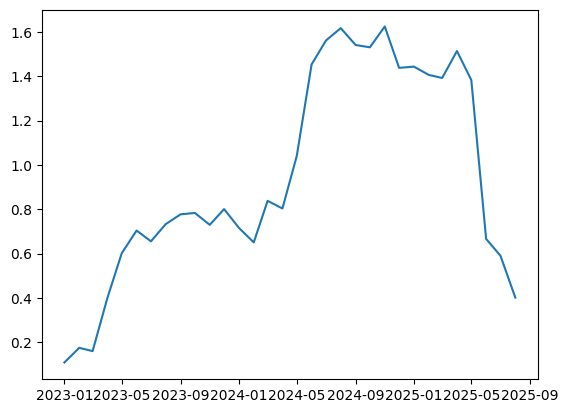

In [94]:
df = pd.DataFrame(list(times.items()), columns=['date', 'rate'])

plt.plot(df['date'], df['rate'])
plt.show


In [73]:
at_inception.dtypes

Unnamed: 0                              int64
policy_id                              object
policy_name                            object
age                                     int64
education                              object
gender                                 object
income                                float64
smoker_status                          object
sold_socio_economic_class             float64
orginal individual_income             float64
sale_date                      datetime64[ns]
underwriting_outcome                   object
optionality                           float64
eml                                   float64
pml                                   float64
securitygroup_id                       object
policy_type                            object
benefits_count                        float64
last_benefit_amount                   float64
cover_amount_full                     float64
total_funeral_premium                 float64
funeral_count                     

## Near future lapse

# Grouping continous variables

## at inception

In [46]:
path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/Data2/"
at_inception=pd.DataFrame(pd.read_csv(path+"inception_data_eco_v2.csv"))

#['age','income',
#       'orginal individual_income', 'last_benefit_amount', 'cover_amount_full',
#       'total_funeral_premium',  'original_premium',
#       ]

In [47]:
at_inception.columns
at_inception

Index(['Unnamed: 0', 'policy_id', 'policy_name', 'age', 'education', 'gender',
       'income', 'smoker_status', 'sold_socio_economic_class',
       'occupation_class', 'occupation', 'orginal individual_income',
       'lead_provider_name', 'lead_type', 'sales_channel', 'sale_date',
       'campaign_name', 'underwriting_outcome', 'optionality',
       'hiv_test_required', 'eml', 'pml', 'hiv_group', 'securitygroup_id',
       'policy_type', 'benefits_count', 'last_benefit_amount',
       'cover_amount_full', 'total_funeral_premium', 'funeral_count',
       'original_premium', 'duration_policy_start_delay', '# calls',
       '# calls contacted', 'res_code_QA_sum', 'res_code_claims_sum',
       'res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
       'res_code_update_sum', 'policy_status', 'current_policy_status',
       'cancellation_effective_date', 'cancellation_reason', 'lapse_type',
       'lapse_flag', 'cover_

In [48]:
at_inception=at_inception.drop(columns=['Unnamed: 0','orginal individual_income', 'policy_id', 'sale_date', 'policy_type',
       'policy_status',
       'current_policy_status', 'cancellation_effective_date',
       'cancellation_reason', 'lapse_type','cover_start_date', 'end_date', 'pol_duration'
      ])

In [49]:
at_inception.shape[0]

22336

Grouping continous variables using decision trees, limiting the tree to only create branches if the branch size (no. policies in that band) is more that 15% of the dataset. This means maximum of 6 bands

In [50]:
cont_var_list=['age','income',  'last_benefit_amount', 'cover_amount_full', 'total_funeral_premium',  'original_premium']
target='lapse_flag'
df=at_inception.copy()
for variable in cont_var_list:
    X = df[variable].values.reshape(-1, 1)
    Y = df[target]
    clf=tree.DecisionTreeClassifier(min_samples_leaf=math.floor(0.15*at_inception.shape[0]))
    clf=clf.fit(X,Y)
    df[variable+'_band'] = group_by_decision_tree(clf, df[variable], df)
df=df.drop(columns=cont_var_list)
df.to_csv(path+"inception_data_eco_v3.csv")


In [51]:
df

,policy_name,education,gender,smoker_status,sold_socio_economic_class,occupation_class,occupation,lead_provider_name,lead_type,sales_channel,...,1month_lapse,3month_lapse,6month_lapse,ann_lapse,age_band,income_band,last_benefit_amount_band,cover_amount_full_band,total_funeral_premium_band,original_premium_band
0,ML24-0199554,Matric + 3 year Diploma,Female,N,2.0,A,Administrator,Recycled Freemium,External Call Centre,Agent,...,0,0,0,0.0,< 32.50,16194.50 - 26846.00,> 1666875.00,> 1005833.34,< 8.27,< 280.76
1,ML24-0254853,Matric + 3 year Diploma,Female,E,1.0,A,Personal Assistant,SPL-Freemium,Affiliate,Agent,...,0,0,0,NaN,> 50.50,> 37462.50,< 110120.46,< 100030.60,< 8.27,280.76 - 385.28
2,ML23-0067459,Matric + 3 year Diploma,Male,S,1.0,A,Chief Technology Officer (CTO) (< 20% travel),Sold Freemium,External Call Centre,Agent,...,0,0,0,0.0,38.50 - 43.50,> 37462.50,< 110120.46,100030.60 - 200015.62,< 8.27,< 280.76
3,ML24-0141499,Matric,Male,S,2.0,B,Sales Representative (> 10% travel),MWL Phone Leads,Inbound Phone Call,Agent,...,0,0,0,0.0,> 50.50,16194.50 - 26846.00,110120.46 - 498472.00,200015.62 - 477116.67,< 8.27,280.76 - 385.28
4,ML23-0055778,Matric,Female,N,2.0,A,Admissions Clerk,Sold Freemium,Affiliate,Agent,...,1,1,1,NaN,38.50 - 43.50,16194.50 - 26846.00,1003478.84 - 1666875.00,> 1005833.34,< 8.27,280.76 - 385.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22331,ML25-0356266,Matric,Male,N,2.0,E,Driver - Heavy vehicle,Lead Warming,External Call Centre,Agent,...,0,0,0,NaN,43.50 - 50.50,16194.50 - 26846.00,110120.46 - 498472.00,100030.60 - 200015.62,< 8.27,< 280.76
22332,ML23-0086391,Matric,Female,N,4.0,A,Salesperson (< 10% travel),LeadWarming,External Call Centre,Agent,...,0,0,0,1.0,32.50 - 38.50,< 9370.00,< 110120.46,< 100030.60,8.27 - 75.47,< 280.76
22333,ML23-0038583,Matric,Male,N,3.0,A,Personal Assistant,Sold Freemium,Affiliate,Agent,...,0,0,0,0.0,< 32.50,9370.00 - 16194.50,498472.00 - 1003478.84,200015.62 - 477116.67,8.27 - 75.47,< 280.76
22334,ML23-0118810,Matric,Male,N,3.0,D,Driver - Light goods,LeadWarming,Affiliate,Agent,...,0,0,0,0.0,> 50.50,9370.00 - 16194.50,498472.00 - 1003478.84,200015.62 - 477116.67,> 163.69,> 596.20


## near future